# Advanced Lane Lines Finding 

In this project our goal is to write a software pipeline to identify the road lane lines in a video from a front-facing camera on a car. We will detect and calculate curved line as well as detecting the relative position of the car with regard to the center of the road. In order to acheive please find bellow our action plan :

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image. 
4. Apply a perspective transform to rectify our image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Final pipeline implementation.
10. Test our pipeline for video processing.

## 1. Camera Calibration

### Imports

Thanks to OpenCV most of the function needed for us to Calibrating our camera will be native OpenCV function , lets do our imports!

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

### Define our calibration function

In order for use to calibrate our camera we will use a chessboard of wich we know the dimensions and number of intercection.
The number of corners in any given row will be noted nx. Similarly,the number of corners in a given column will be noted ny.
Taking different picture of the chessboard under different angles we will allow us to calibrate our camera.

In [243]:
def camera_calibration(images, nx, ny):
    
    #Prepare object points
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].transpose().reshape(-1, 2)
    objpoints = []
    imgpoints = []
    
    for sample_img in images:
        
        #read image
        img = cv2.imread(sample_img)       
        #get image size
        img_size = (img.shape[1], img.shape[0])  
        #convert our image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      
        #find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #if corners found
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    #calculate the camera calibration matrix and the distortion coefficient based on our objectpoint and image points
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)   
    return mtx, dist

In [244]:
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

Now that we have been calculating the calibration matrix and the distortion coefficients we can know undistorted image comming from the camera.

## 2. Image distortion
Lets use the previous calibration matrix and the distortion coefficients to build an image undistort function

In [245]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Apply a distortion correction to a raw image

(-0.5, 1279.5, 719.5, -0.5)

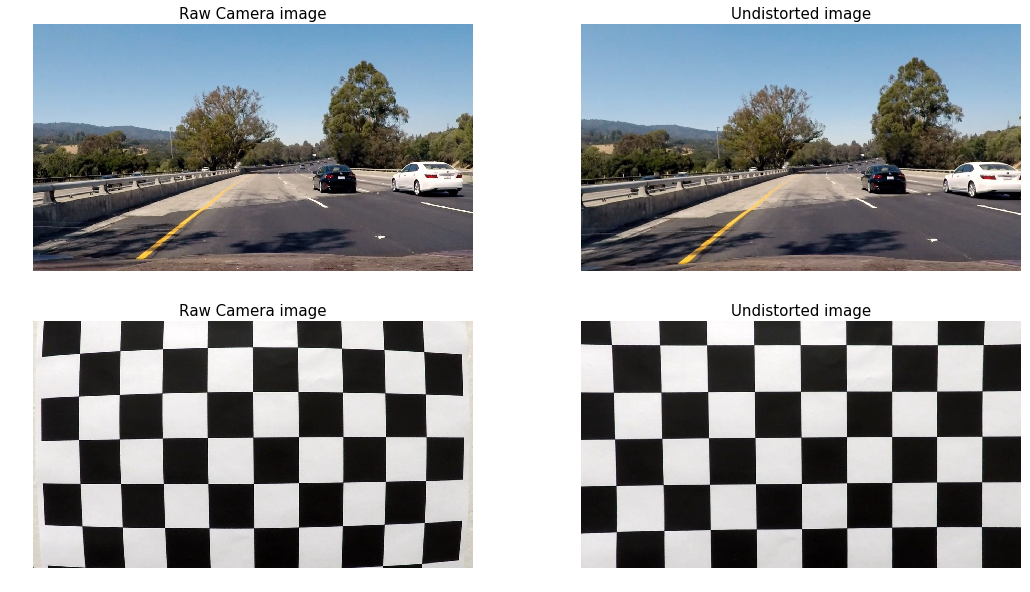

In [246]:
#Lets apply a distortion correction to a raw image and check the result
test_img = plt.imread("test_images/test4.jpg")
undist_test_img = undistort(test_img)

chess = plt.imread("camera_cal/calibration1.jpg")
undist_chess = undistort(chess)

fig = plt.figure(figsize=(18, 10))
plt.subplot(2,2,1)
plt.imshow(test_img)
plt.title('Raw Camera image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(undist_test_img)
plt.title('Undistorted image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(chess)
plt.title('Raw Camera image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(undist_chess)
plt.title('Undistorted image',fontsize=15)
plt.axis('off')

We can know undistort images from the camera and start to work on our pipeline ! Please note that I have displayed a chessboard image so that the undistortion get more visible for our human eyes but it can be seen also on our test image looking at the car hood for instance.

## 3.  Creating a thresholded binary image 

### Colorspace 
In this section we will explore different colorpsace and select the one that will be the most useful for us to detect the lane line.

(-0.5, 1279.5, 719.5, -0.5)

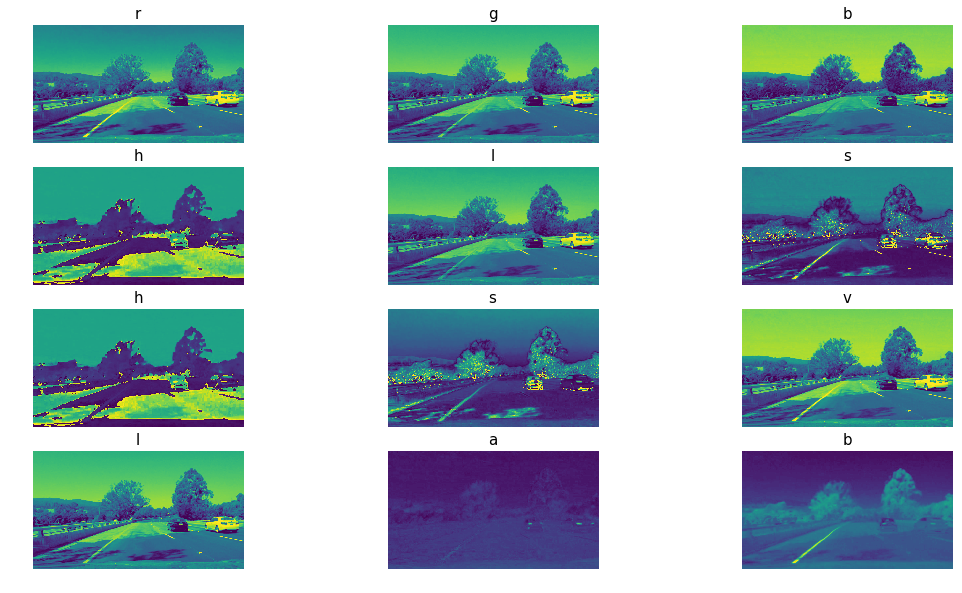

In [247]:
#initial RGB image
rgb = test_img

r_channel = rgb[:,:,0]
g_channel = rgb[:,:,1]
b_channel = rgb[:,:,2]

#HLS colorspace
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)

hls_h_channel = hls[:,:,0]
hls_l_channel = hls[:,:,1]
hls_s_channel = hls[:,:,2]

#HSV colorspace
hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)

hsv_h_channel = hsv[:,:,0] #h – Hue ( Dominant Wavelength ).
hsv_s_channel = hsv[:,:,1] #s – Saturation ( Purity / shades of the color ).
hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).

#LAB colorspace
lab = cv2.cvtColor(test_img, cv2.COLOR_RGB2Lab)

lab_l_channel = lab[:,:,0] #l – Lightness ( Intensity ).
lab_a_channel = lab[:,:,1] #a – color component ranging from Green to Magenta.
lab_b_channel = lab[:,:,2] #b – color component ranging from Blue to Yellow.


fig = plt.figure(figsize=(18, 10))
#rgb
plt.subplot(4,3,1)
plt.imshow(r_channel)
plt.title('r',fontsize=15)
plt.axis('off')
plt.subplot(4,3,2)
plt.imshow(g_channel)
plt.title('g',fontsize=15)
plt.axis('off')
plt.subplot(4,3,3)
plt.imshow(b_channel)
plt.title('b',fontsize=15)
plt.axis('off')

#hls
plt.subplot(4,3,4)
plt.imshow(hls_h_channel)
plt.title('h',fontsize=15)
plt.axis('off')
plt.subplot(4,3,5)
plt.imshow(hls_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(4,3,6)
plt.imshow(hls_s_channel)
plt.title('s',fontsize=15)
plt.axis('off')

#hsv
plt.subplot(4,3,7)
plt.imshow(hsv_h_channel)
plt.title('h',fontsize=15)
plt.axis('off')
plt.subplot(4,3,8)
plt.imshow(hsv_s_channel)
plt.title('s',fontsize=15)
plt.axis('off')
plt.subplot(4,3,9)
plt.imshow(hsv_v_channel)
plt.title('v',fontsize=15)
plt.axis('off')

#lab
plt.subplot(4,3,10)
plt.imshow(lab_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(4,3,11)
plt.imshow(lab_a_channel)
plt.title('a',fontsize=15)
plt.axis('off')
plt.subplot(4,3,12)
plt.imshow(lab_b_channel)
plt.title('b',fontsize=15)
plt.axis('off')

We can see that the hls s channel give pretty consistent result for both blank and white line , without being too much impacted by shadow. the LAB B channel sounds pretty good at detecting yellow lane as well and respectively the l channel for the white lane.Lets see if we can filter the hls_l_channel and the lab_b_channel to further improve the results.

#### Thresholding the hls l channel

After testing we've dcided to implement a map function so we can adapt our thershold with regards to the image HSV V channel mean value

In [248]:
def map_threshold_hls_l(value):

    HSV_means = [57, 79,100, 135, 140, 150]
    HLS_thresholds = [173, 175,190, 190, 215, 215]
    value = np.interp(value, HSV_means, HLS_thresholds)  
    return value

In [249]:
map_threshold_hls_l(79)

175.0

In [250]:
#convert rgb image to hls , isolate the l channel , thershold it and return a binary image

def img_to_threshold_hls_l(img,setmin=None):
    
    if setmin != None:
        min =setmin
    else:
        #HSV colorspace for adaptive filtering
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).
        #Adaptive thresholding
        min = map_threshold_hls_l(hsv_v_channel.mean())
    max =255
    # convert img to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #isolate the l channel
    hls_l = hls[:,:,1]
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(hls_l)
    #threshold the l channel and return a binary image
    thresholded_img[(hls_l > min) & (hls_l <= max)] = 1
    return thresholded_img

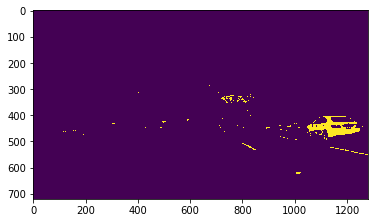

In [251]:
plt.imshow(img_to_threshold_hls_l(test_img))

We can see that our thresholding make a good job at detecting the white line

#### Thresholding the lab b channel

In [289]:
def map_threshold_lab_b(value):

    HSV_means = [57, 79, 129, 135, 140, 150]
    LAB_thresholds = [150, 150, 150, 160, 160, 160]
    value = np.interp(value, HSV_means, LAB_thresholds)  
    return value

In [290]:
#convert rgb image to lab , isolate the b channel , thershold it and return a binary image

def img_to_threshold_lab_b(img,setmin=None):
    
    if setmin != None:
        min =setmin
        
    else:
        #HSV colorspace for adaptive filtering
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).
        #Adaptive thresholding
        min = map_threshold_lab_b(hsv_v_channel.mean())
    max =255
    # convert img to lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    #isolate the b channel
    lab_b = lab[:,:,2]
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(lab_b)
    #thershold the s channel and return a binary image
    thresholded_img[(lab_b > min) & (lab_b <= max)] = 1
    return thresholded_img

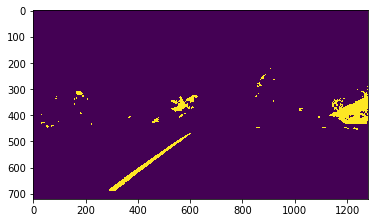

In [291]:
plt.imshow(img_to_threshold_lab_b(test_img))

We can clearly see that this thresholding make a good job at detecting the yellow line.

#### Combining the color channels

In [292]:
def augmented_colorspace(img):
    hls_l = img_to_threshold_hls_l(img)
    lab_b = img_to_threshold_lab_b(img)
    combined_binary = np.zeros_like(lab_b)
    combined_binary[(hls_l == 1) | (lab_b == 1)] = 1
    return combined_binary

##### Display the result

(-0.5, 1279.5, 719.5, -0.5)

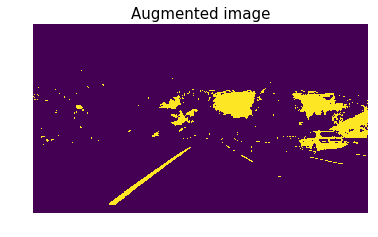

In [293]:
augmented_image = augmented_colorspace(test_img)
plt.imshow(augmented_image)
plt.title('Augmented image',fontsize=15)
plt.axis('off')

Alright the result look very promising as we can easily detect both lines lets continue building our pipeline !

### Gradient

lets use the sobel operator at the heart of the Canny edge detection algorithm to compute vertical gradients to best detect our line.

In [294]:
def sobel_x_threshold(img, thresh_min=30 , thresh_max=100):
    
    #Image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

(-0.5, 1279.5, 719.5, -0.5)

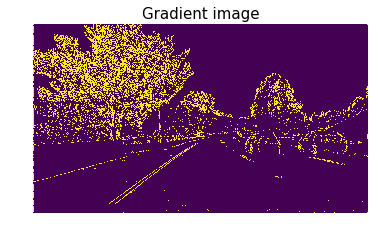

In [295]:
gradient_image = sobel_x_threshold(test_img)
plt.imshow(gradient_image)
plt.title('Gradient image',fontsize=15)
plt.axis('off')

In [296]:
def sobel_y_threshold(img, thresh_min=20 , thresh_max=100):
    
    #Image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
     # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sybinary

(-0.5, 1279.5, 719.5, -0.5)

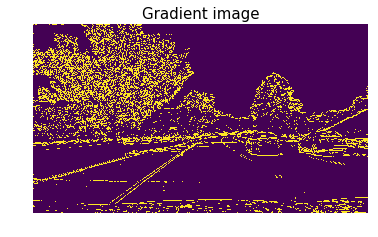

In [297]:
gradient_image = sobel_y_threshold(test_img)
plt.imshow(gradient_image)
plt.title('Gradient image',fontsize=15)
plt.axis('off')

The gradient filtering doesn't seems to add more than the color channel filtering , lets keep only the colorspace filtering mooving forward in our pipeline 



## 4. Region of interest and Perspective transform  



At this stage we have had good results with detecting the lane, lets now definie a region of interest and do a perspective transform

In [298]:
def bird_eye_view(img, getMinv=False):
    #set dest and source point
    src = np.float32([(575,464),(707,464),(258,682),(1049,682)])
    dst = np.float32([(450,0),(img.shape[1]-450,0),(450,img.shape[0]),(img.shape[1]-450,img.shape[0])])
    
    #get the perpective transform Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #get theinverse transform Matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use warp the image
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    if getMinv==False:
        return warped
    else:
        return warped, Minv

Text(0.5,1,'initial image')

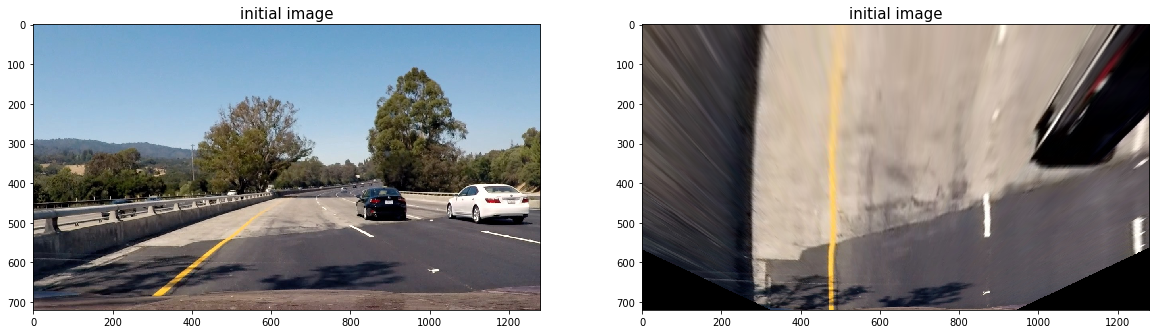

In [299]:
test_img = plt.imread("test_images/test4.jpg") 
fig = plt.figure(figsize=(20, 50))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('initial image',fontsize=15)

plt.subplot(1,2,2)
plt.imshow(bird_eye_view(test_img))
plt.title('initial image',fontsize=15)

Here are our bird eye view image ! Lets test it on other sample images !

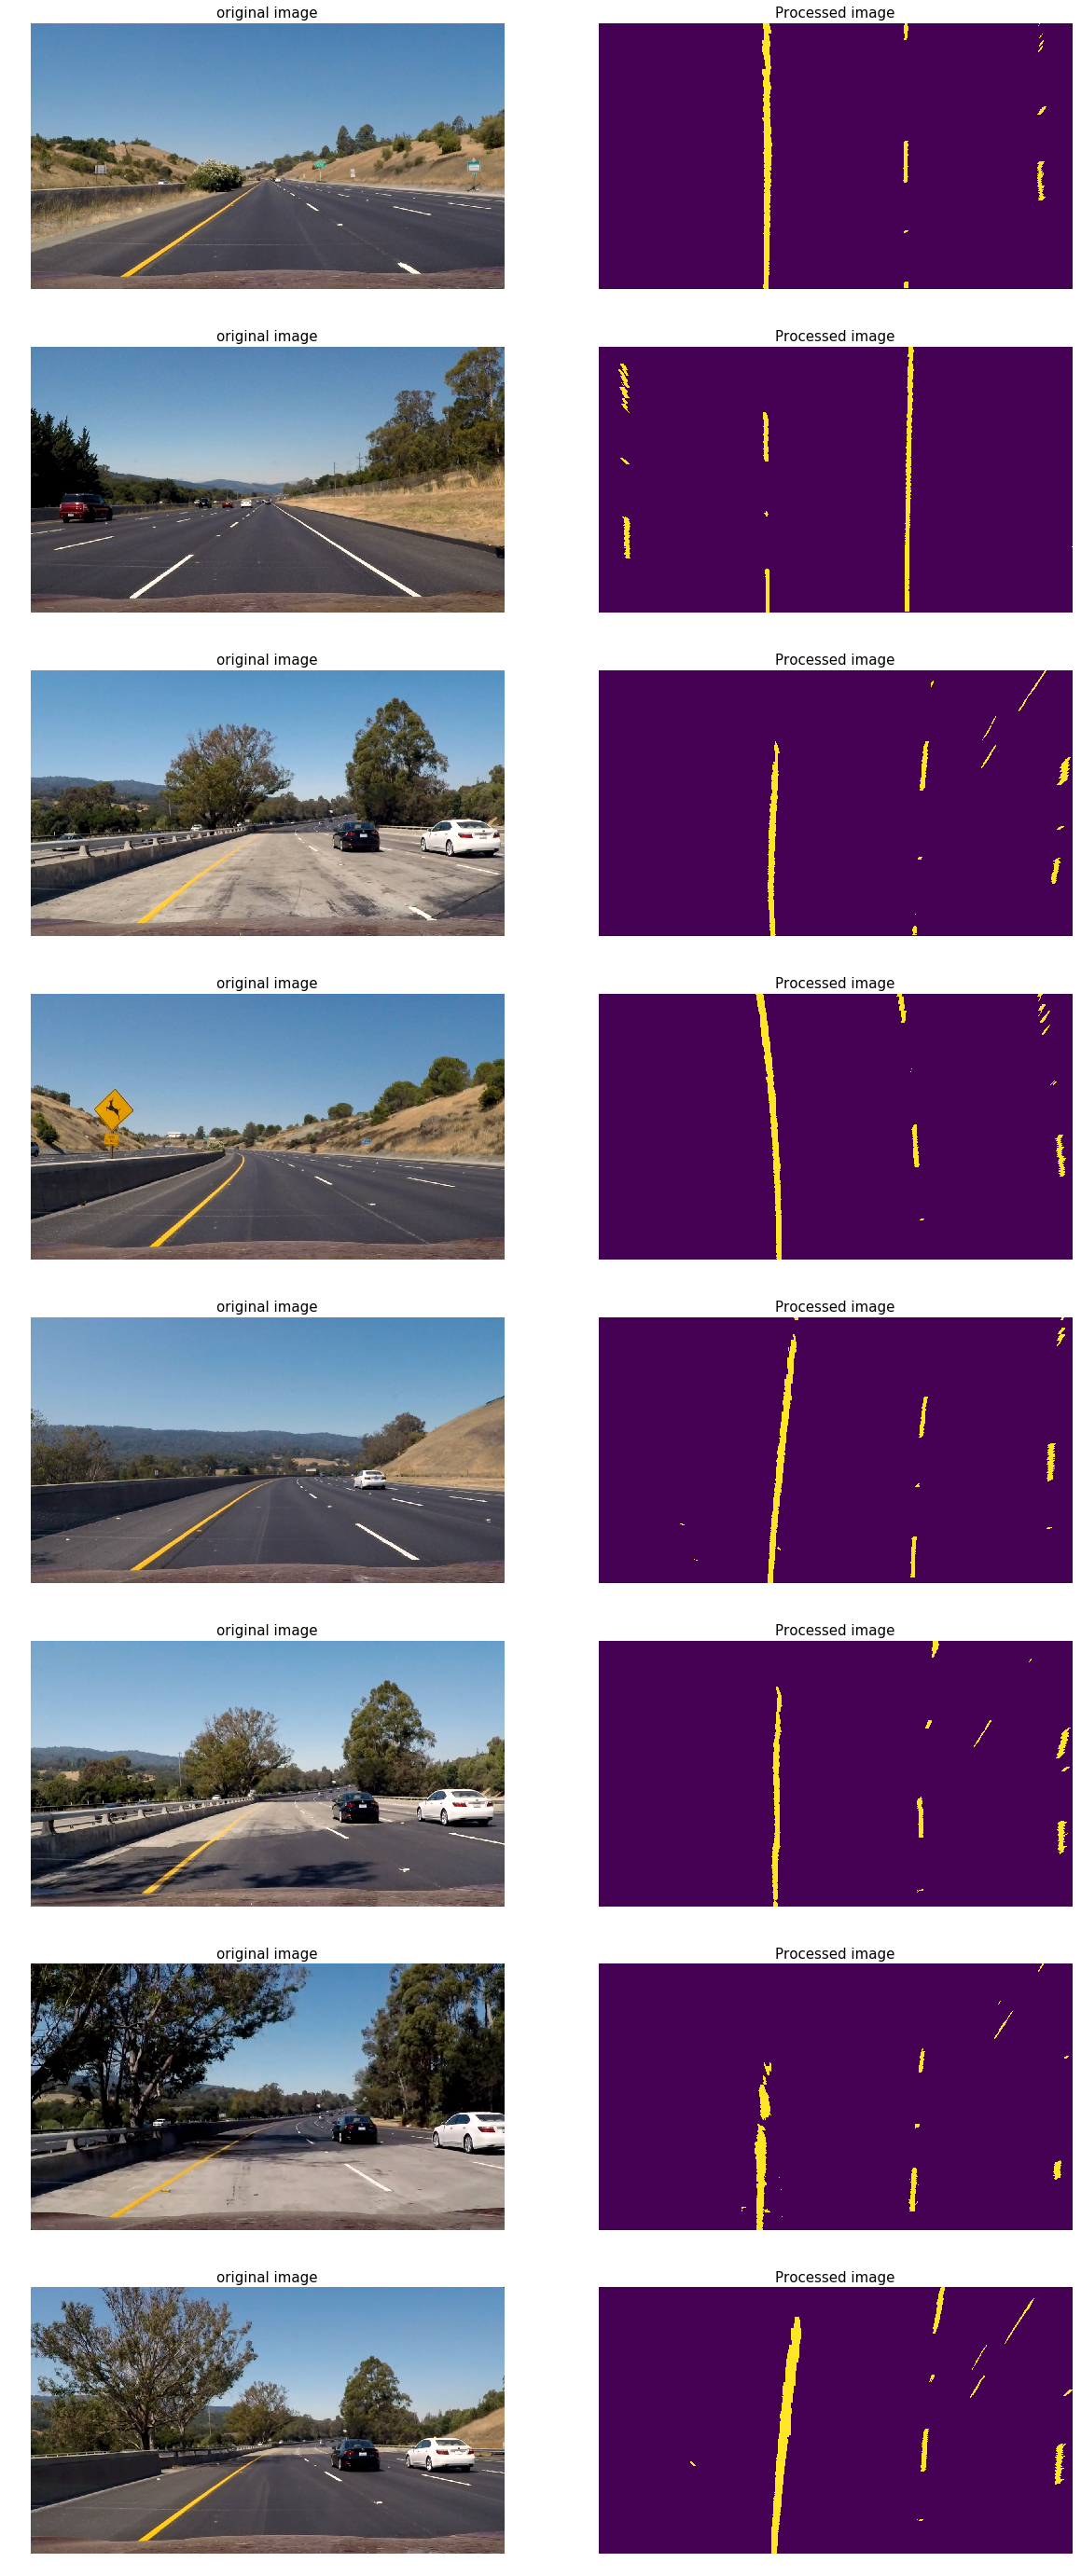

In [300]:
test_img = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(20, 50))
i=1

for img_path in test_img:
    img = plt.imread(img_path)
    
    plt.subplot(8,2,i)
    plt.imshow(img)
    plt.title('original image',fontsize=15)
    plt.axis('off')
    i=i+1
    plt.subplot(8,2,i)
    plt.imshow(bird_eye_view(augmented_colorspace(img)))
    plt.title('Processed image',fontsize=15)
    plt.axis('off')
    i=i+1

Unless tiny noise , we can see that our model is doing pretty good , lets continue to design our pipeline , time to Detect lane pixels and fit to find the lane boundary !

## 5. Detect lane pixels and fit to find the lane boundary

At this stage , we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

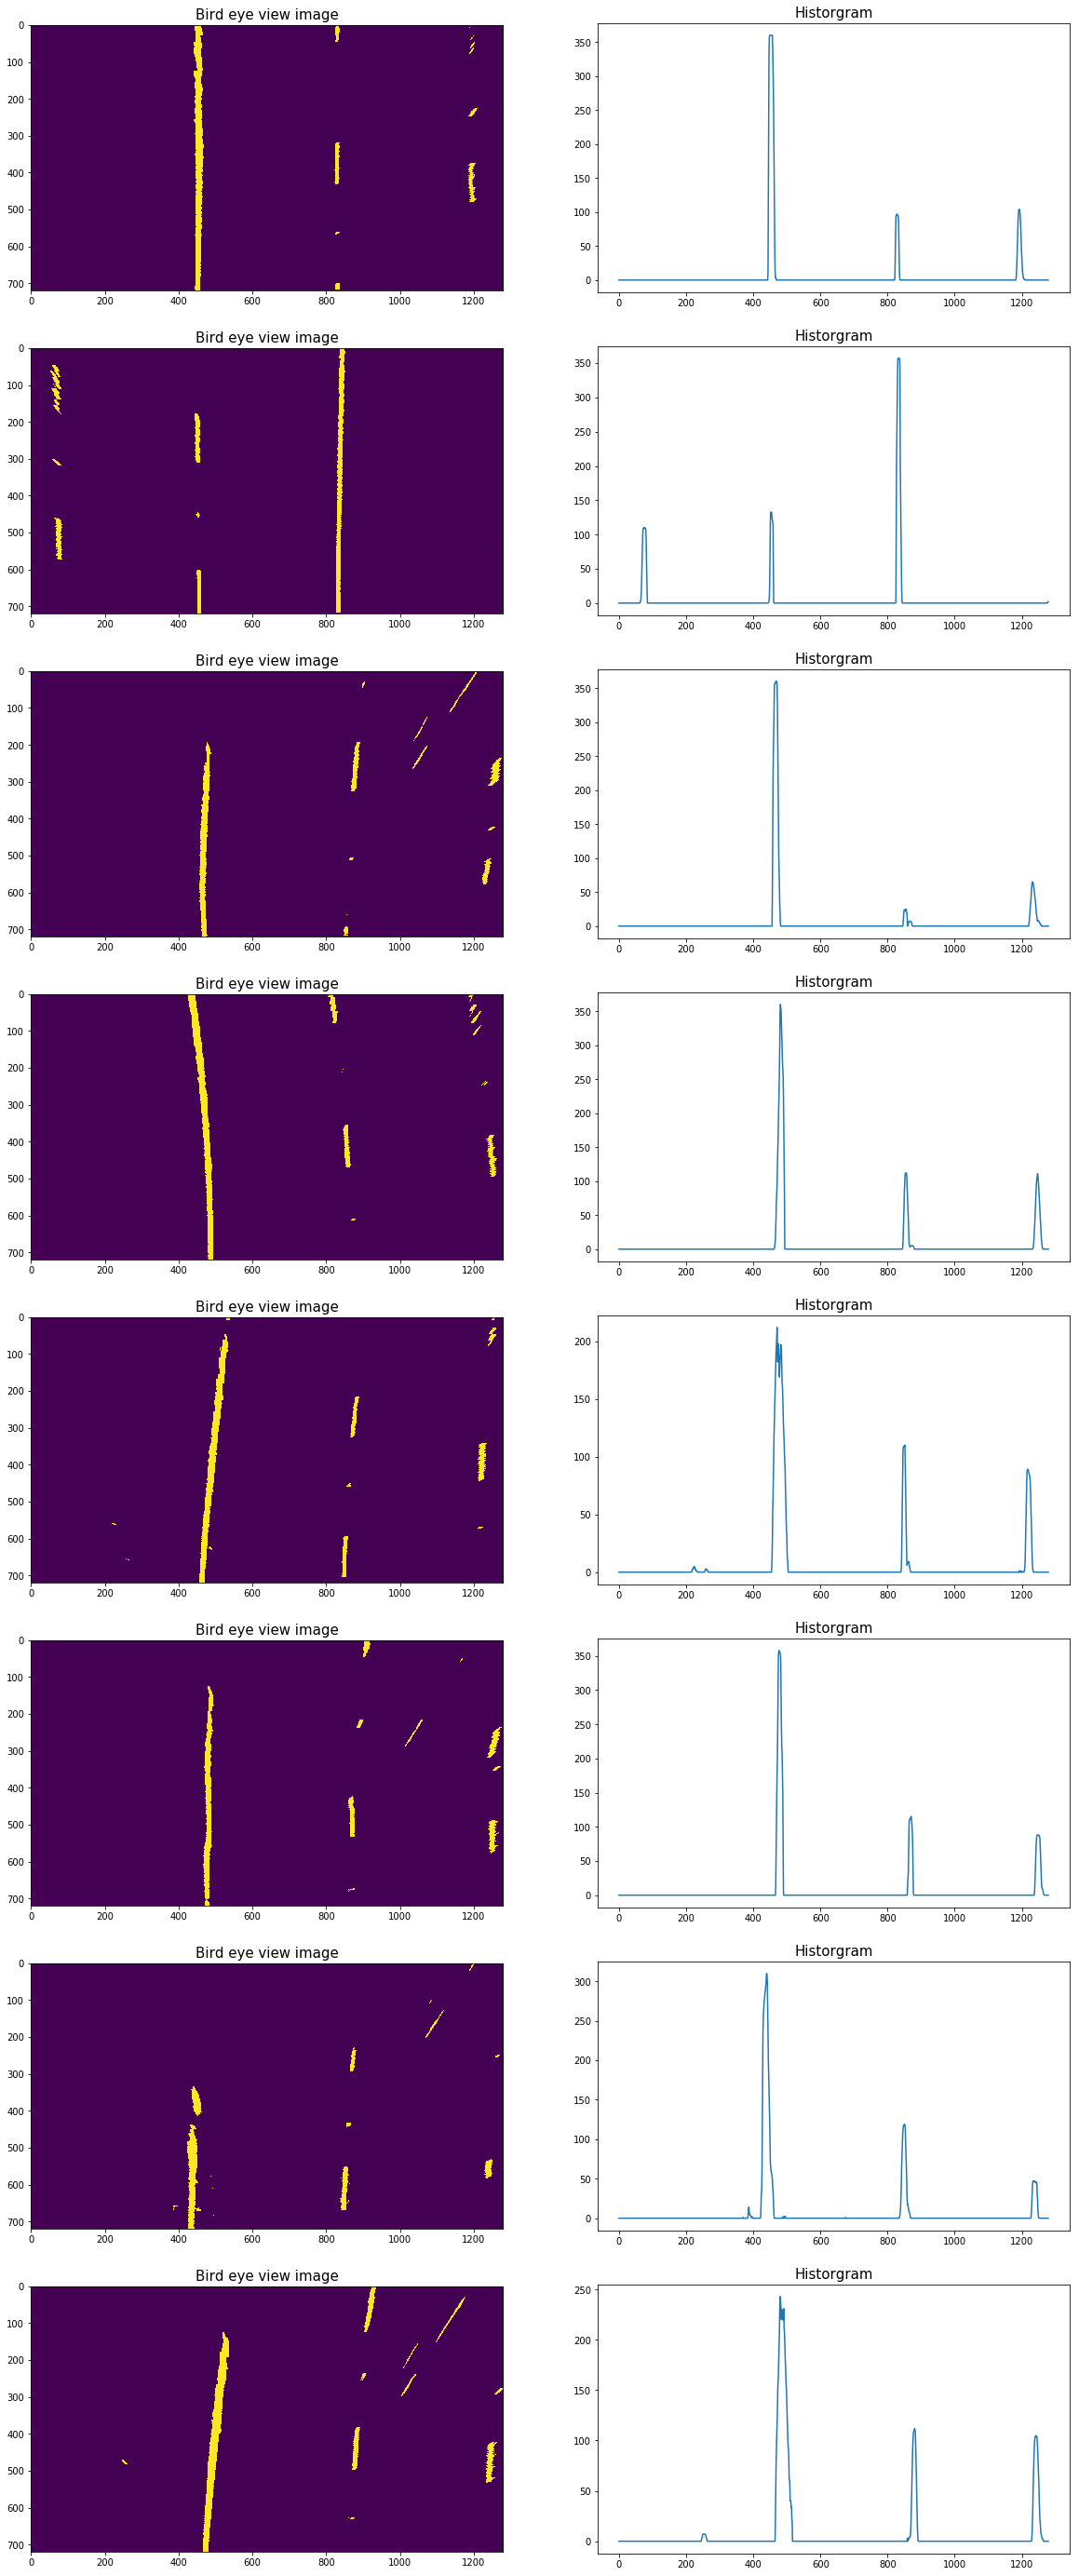

In [264]:
test_img = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(20, 50))
i=1

for img_path in test_img:
    
    img = plt.imread(img_path)
    augmented_img = bird_eye_view(augmented_colorspace(img))
    
    plt.subplot(8,2,i)
    plt.imshow(augmented_img)
    plt.title('Bird eye view image',fontsize=15)
    i=i+1
    
    plt.subplot(8,2,i)
    histogram = np.sum(augmented_img[augmented_img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.title('Historgram',fontsize=15)
    i=i+1

With this histogram we will be adding up the pixel values along each column in the image. as in our thresholded binary image, pixels are either 0 or 1, the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. we can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

### First fit search

In [265]:
def first_polynomfit_with_sliding_windows(img):

    #look at the bottom part of the image and sum pixels values
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    #cut the bottom image in 4 part (3 separations) and get the max value for each part
    point_1 = np.int(np.int(histogram.shape[0]//4));
    point_2 = np.int(np.int(histogram.shape[0]//2));
    point_3 = point_2 + point_1

    #get the argmax for each part
    max_section_1 = np.argmax(histogram[:point_1])
    max_section_2 = np.argmax(histogram[point_1:point_2]) + point_1
    max_section_3 = np.argmax(histogram[point_2:point_3]) + point_2
    max_section_4 = np.argmax(histogram[point_3:]) + point_3

    #lets assume the closest line to the center of the image taken by the camera centered on the car
    #correspond to the line of the road section we are

    detected_lane_list=[max_section_1,max_section_2,max_section_3,max_section_4]   

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    first_lane=find_nearest(detected_lane_list,histogram.shape[0]//2)
    detected_lane_list.remove(first_lane)
    second_lane=find_nearest(detected_lane_list,histogram.shape[0]//2)

    #awesome we have the 2 lane corresponding to our driving section but which is the left and th right lane ?

    if second_lane > first_lane:
        leftx_base = first_lane
        rightx_base = second_lane
    else:
        leftx_base = second_lane
        rightx_base = first_lane
        
        print(leftx_base,rightx_base)
        
    #Allright we have identifyed our left and right lane base!
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    #save rectangle
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # save the rectangles
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles   

#### Visualization and test of our first fit search function

[(648, 720, 377, 577, 770, 970), (576, 648, 376, 576, 768, 968), (504, 576, 375, 575, 768, 968), (432, 504, 379, 579, 769, 969), (360, 432, 381, 581, 768, 968), (288, 360, 380, 580, 768, 968), (216, 288, 379, 579, 768, 968), (144, 216, 382, 582, 790, 990), (72, 144, 386, 586, 790, 990), (0, 72, 383, 583, 790, 990)]


(720, 0)

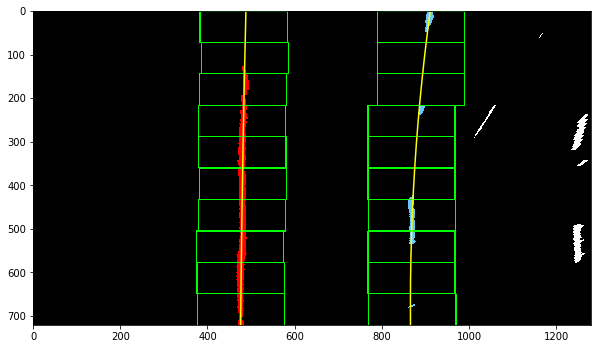

In [266]:
#load our test image
test_img = plt.imread("test_images/test4.jpg") 
augmented_img = bird_eye_view(augmented_colorspace(test_img))
rectangles = []

#apply our search function
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(augmented_img)

print(rectangles)

# Generate x and y values for plotting
ploty = np.linspace(0, augmented_img.shape[0]-1, augmented_img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((augmented_img, augmented_img, augmented_img))*255)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = augmented_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

#draw the rectangles used in the window search
for i in range(len(rectangles)):
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rectangles[i][2],rectangles[i][0]),(rectangles[i][3],rectangles[i][1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rectangles[i][4],rectangles[i][0]),(rectangles[i][5],rectangles[i][1]),(0,255,0), 2) 
    
fig = plt.figure(figsize=(10, 30))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Awesome , we managed to fit a second order polynome to our detected lane line using a windows search, as the lane lines position in the next image of a videoframe is likely to have +- the same position we won't run this detection algorithme each time but instead just search in a margin around the previous line position a starting point for the next frame. 

### Next fit search

In [267]:
def next_polynomfit_with_sliding_windows(img, old_left_fit, old_right_fit,margin=100):
      
    #get non zeros pixel from image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((nonzerox > (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] - margin)) & 
                      (nonzerox < (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] - margin)) & 
                       (nonzerox < (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
     
     # Fit a second order polynomial to each
    if len(leftx) != 0:
        new_left_fit = np.polyfit(lefty, leftx, 2)
    else:
        new_left_fit=None      
    if len(rightx) != 0:
        new_right_fit = np.polyfit(righty, rightx, 2)
    else:
        new_right_fit=None      
    return new_left_fit, new_right_fit, left_lane_inds, right_lane_inds, margin

Awesome , lets now used some images to test our function , test images 4,5 and 6 will be adapted as they follow each other and can moke a video frame just for testing

#### Visualization and testing of our Next fit search function

(720, 0)

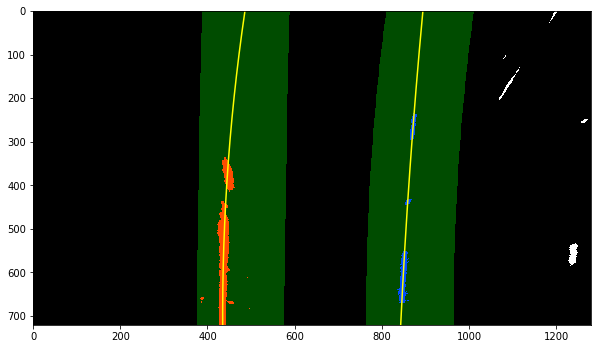

In [268]:
#load our test image
test_img = plt.imread("test_images/test4.jpg") 
augmented_img1 = bird_eye_view(augmented_colorspace(test_img))

test_img = plt.imread("test_images/test5.jpg") 
augmented_img2 = bird_eye_view(augmented_colorspace(test_img))

#apply our initial search function
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(augmented_img1)

#apply our next search function
new_left_fit, new_right_fit, new_left_lane_inds, new_right_lane_inds, margin = next_polynomfit_with_sliding_windows(augmented_img2,left_fit,right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, augmented_img2.shape[0]-1, augmented_img2.shape[0] )

#old fit
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#new fit
new_left_fitx = new_left_fit[0]*ploty**2 + new_left_fit[1]*ploty + new_left_fit[2]
new_right_fitx = new_right_fit[0]*ploty**2 + new_right_fit[1]*ploty + new_right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((augmented_img2, augmented_img2, augmented_img2))*255
window_img = np.zeros_like(out_img)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = augmented_img2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[new_left_lane_inds], nonzerox[new_left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[new_right_lane_inds], nonzerox[new_right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
fig = plt.figure(figsize=(10, 30))
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(new_left_fitx, ploty, color='yellow')
plt.plot(new_right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

It sounds like our lightweight search functionperform well based on our margin aproximation,  it time to continue exctracting information from these lines.

## 6. Determine the curvature of the lane and vehicle position with respect to center.

Now that we were able to modelize our lanes with a polynome , lets build a function that would help us calculating the curvature of the lane and the position with respect to the center of our vehicle.

#### Curvature of the lane and center position

In [269]:
def get_curve_and_center(img,left_fit, right_fit, left_lane_inds, right_lane_inds):
   
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # get the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        #Define value where we evaluate the radius (here we will evaluate it at the bottom of the image)
        ploty_l = np.linspace(0, img.shape[0]-1, len(leftx))
        ploty_r = np.linspace(0, img.shape[0]-1, len(rightx))
        y_eval = np.max(ploty_l)
    
    left_curverad = None
    right_curverad = None
    curvature = None
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty_l*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty_r*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        curvature = (left_curverad + right_curverad) / 2
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
    
    #calculate the distance from the center , thank you to jeremy-shannon for his help on the formula for this part
    #where Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    center_dist_m = None
    if left_fit is not None and right_fit is not None:
        
        #Assuming the camera is perfectly centered on the car
        car_position = img.shape[1]/2
        #calculate left and right intercetion point with midpoint
        left_fit_x_intercept = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
        right_fit_x_intercept = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
        #Determine the road center
        road_center = (right_fit_x_intercept + left_fit_x_intercept) /2
        center_dist = (car_position - road_center) 
        #get the value in meters
        center_dist_m = center_dist* xm_per_pix
    
    return  curvature,left_curverad, right_curverad, center_dist_m

#### Curvature of the lane and center position - Test

In [270]:
#load our test image
test_img = plt.imread("test_images/test6.jpg") 
augmented_img1 = bird_eye_view(augmented_colorspace(test_img))

#apply our initial search function
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(augmented_img1)
curvature,left_curverad, right_curverad, center_dist_m = get_curve_and_center(img ,left_fit, right_fit, left_lane_inds, right_lane_inds)

print("Curvature :",curvature, "center_dist_m :",center_dist_m)

Curvature : 689.5764972405831 center_dist_m : -0.15354259134974646


Our function now work and is able to calculate the curvature and the distance of the car relative to the center of the road !

## 7. Warp the detected lane boundaries back onto the original image.

Now that we were able to detect lanes , modelise both of them with a 2nd order polynom and calculate the radius and the relative car center position, it is time to display these information back on to the original image.

In [281]:
def draw_lanes(img, augmented_img, left_fit, right_fit, Minv):
    
    #handle the possibility where we miss fitting a frame in the videoframe
    if left_fit is not None and right_fit is not None:
        print("left_fit",left_fit)
        print("right_fit",right_fit)
        # Create an empty image that will be loaded with our targeted result
        drawing_img = np.zeros_like(augmented_img).astype(np.uint8)
        drawing_img = np.dstack((drawing_img, drawing_img, drawing_img))

        # Generate x and y values for plotting
        ploty = np.linspace(0, augmented_img.shape[0]-1, augmented_img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # lets now Draw the lane on our result image using opencv
        
        #Draw the left lane in red (like the aerospace navigation lights)
        cv2.polylines(drawing_img, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=13)
        #Draw the right lane in green (like the aerospace navigation lights)
        cv2.polylines(drawing_img, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=13)
        #Draw a blue surface between the 2 lanes
        cv2.fillPoly(drawing_img, np.int_([pts]), (0,0, 255))
        
        #lets transform our image to fit in the original perspective
        drawing_img = cv2.warpPerspective(drawing_img, Minv, (img.shape[1], img.shape[0])) 
        
        
        #assertion check before merging
        assert drawing_img.shape[0] == img.shape[0]
        assert drawing_img.shape[1] == img.shape[1]
        
        #lets use cv2 to add our original image with our drawings ,
        #we will use the blend function to give a 50% transaprency effect to our drawing
        out_img = cv2.addWeighted(img, 1, drawing_img, 0.5,0)
        
        return out_img
    else:
        return img  

#### Function testing


left_fit [ 4.83955960e-05 -1.40421457e-01  5.47562413e+02]
right_fit [ 8.45050565e-05 -1.44289236e-01  9.26630784e+02]


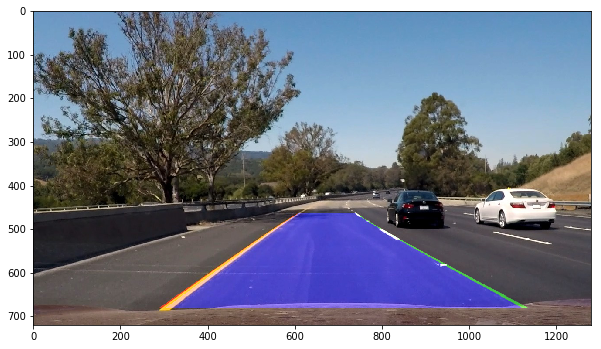

In [282]:
#load our test image
img = plt.imread("test_images/test6.jpg") 
augmented_img1, Minv = bird_eye_view(augmented_colorspace(img),getMinv=True)

#apply our initial search function
left_fit, right_fit,_,_,_ = first_polynomfit_with_sliding_windows(augmented_img1)

#apply our draw line function and display the result
fig = plt.figure(figsize=(10, 30))
plt.imshow(draw_lanes(img, augmented_img, left_fit, right_fit, Minv))

Our draw_lanes function seems to work fine and we can now thee the result on our image, lets now add the captured information on top of the image using opencv.

 ## 8. Output visual display for the numerical estimation of lane curvature and vehicle position.

In [273]:
def draw_data(img, curvature, center_dist_m):
    
    out_img = img
    if curvature is not None and center_dist_m is not None: 
        #Text string to be drawn.
        if curvature <=0:
            text1 = "Road direction     : <- (Left )"
        else:
            text1 = "Road direction     : -> (Right)"

        text2 = "Lane curve radius : " + '{:04.2f}'.format(curvature) +"m"
        text3 = "Center distance    : "+ '{:04.3f}'.format(center_dist_m) +"m"

        #Bottom-left corner of the text string in the image.
        org1 = (40,75)
        org2 = (40,125)
        org3 = (40,175)

        #font – CvFont 
        font = cv2.FONT_HERSHEY_DUPLEX  
        #fontScale – Font scale factor that is multiplied by the font-specific base size.
        fontScale = 1.2
        #color – Text color.
        color =(255,255,255)
        #thickness – Thickness of the lines used to draw a text.
        thickness = 2
        #lineType – Line type. See the line for details.
        lineType = cv2.LINE_AA

        # Add Turn direction
        cv2.putText(img, text1, org1, font, fontScale, color, thickness, lineType)

        # Add Radius 
        cv2.putText(img, text2, org2, font, fontScale, color, thickness, lineType)

        # Add Center position 
        cv2.putText(img, text3, org3, font, fontScale, color, thickness, lineType)

        return out_img
    else:
        return img

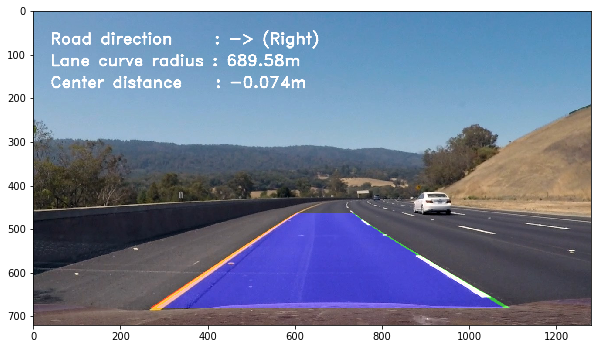

In [274]:
#load our test image
img = plt.imread("test_images/test3.jpg") 
augmented_img1, Minv = bird_eye_view(augmented_colorspace(img),getMinv=True)

#apply our initial search function
left_fit, right_fit,_,_,_ = first_polynomfit_with_sliding_windows(augmented_img1)

#get lane informations
curvature,_, _, center_dist_m = get_curve_and_center(img ,left_fit, right_fit, left_lane_inds, right_lane_inds)

#apply our draw line function and display the result
fig = plt.figure(figsize=(10, 30))
plt.imshow(draw_data(draw_lanes(img, augmented_img, left_fit, right_fit, Minv),curvature,center_dist_m))

We have successfully printed the information on our original sample image. acheiving the end goal for this pipeline,  lets now build the pipeline to process a video input.

## 9. Final Pipeline

left_fit [ 3.82531481e-05 -1.28171796e-01  5.35066783e+02]
right_fit [ 8.47620820e-05 -1.52578190e-01  9.10997519e+02]


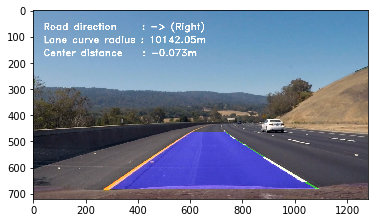

In [283]:
#initial camera calibration 
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

class lane:
    def __init__(self):
        self.isdetected = False
        self.left_fit = []
        self.right_fit = []
        self.average_left_fit = 0
        self.average_right_fit = 0
        
    def log_left_fit(self, left_fit):
        self.left_fit.append(left_fit)
    
    def log_right_fit(self, left_fit):
        self.left_fit.append(left_fit)
        
    def last_right_fit(self):
        #Average on the last 5 frame
        sumfit = 0
        if len(self.left_fit)>6:
            for i in range(5):
                 sumfit = sumfit +self.left_fit[-i+1]
            self.average_left_fit = sumfit/5
            
            
        return self.left_fit[-1]
    
    def last_right_fit(self):
        return self.right_fit[-1]
    
    def isdetected(self):
        return self.isdetected
    
lane = lane()   
        

def Process_video_frame(img):
    
    #undistort the image
    undistorted_img = undistort(img)
    
    #get image augmented colorspace
    aug_img = augmented_colorspace(undistorted_img)
    
    #Transform perspective to bird eye view
    top_aug_img, Minv = bird_eye_view(aug_img, getMinv=True)
    
    if lane_detected == False:
        #first lane search
        left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(top_aug_img)
        lane_detected = True
    else:
        #if lane already detected
        left_fit, right_fit, left_lane_inds, right_lane_inds, margin = next_polynomfit_with_sliding_windows(top_aug_img,left_fit,right_fit)     
          
    #get lane curvature and center distance
    curvature,_, _, center_dist_m = get_curve_and_center(top_aug_img ,left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    #drane lane
    img_with_lane = draw_lanes(img, top_aug_img, left_fit, right_fit, Minv)
    
    #draw data
    img_with_data = draw_data(img_with_lane,curvature,center_dist_m)
    
    return img_with_data

#load our test image
img1 = plt.imread("test_images/test3.jpg") 
#test our pipeline
out_img= Process_video_frame(img1)
plt.imshow(out_img)

## Process the Video with our pipeline

In [306]:
from moviepy.editor import VideoFileClip

output = 'process_output/processed_challenge_video.mp4'
clip1 = VideoFileClip('camera_input/challenge_video.mp4')
output_clip = clip1.fl_image(Process_video_frame)
%time output_clip.write_videofile(output, audio=False)

left_fit [ 3.86531802e-05 -2.51692862e-01  6.47319127e+02]
right_fit [ 1.93633759e-04 -2.09964009e-01  8.92389215e+02]
[MoviePy] >>>> Building video process_output/processed_challenge_video.mp4
[MoviePy] Writing video process_output/processed_challenge_video.mp4


  0%|                                                                                         | 0/485 [00:00<?, ?it/s]

left_fit [ 3.86531802e-05 -2.51692862e-01  6.47319127e+02]
right_fit [ 1.93633759e-04 -2.09964009e-01  8.92389215e+02]
left_fit [ 6.13555260e-05 -2.80696996e-01  6.56274580e+02]
right_fit [ 2.34549812e-04 -2.67246890e-01  9.11946688e+02]


  0%|▎                                                                                | 2/485 [00:00<00:40, 11.94it/s]

left_fit [ 1.87396339e-06 -2.07834103e-01  6.34642701e+02]
right_fit [ 1.25468157e-04 -1.24634361e-01  8.64582343e+02]
left_fit [ 2.61411277e-05 -2.33735746e-01  6.40877506e+02]
right_fit [ 5.14528726e-04 -6.83420062e-01  1.06514751e+03]


  1%|▋                                                                                | 4/485 [00:00<00:41, 11.59it/s]

left_fit [ 7.71682584e-05 -2.94854684e-01  6.59794812e+02]
right_fit [ 2.77310694e-03 -3.86698171e+00  2.18615300e+03]
left_fit [ 3.07122002e-04 -5.79510405e-01  7.47295546e+02]
right_fit [ 1.53911118e-02 -2.19890068e+01  8.69277558e+03]


  1%|█                                                                                | 6/485 [00:00<00:41, 11.59it/s]

493 640
492 640


  2%|█▎                                                                               | 8/485 [00:00<00:38, 12.42it/s]

left_fit [ 1.26926667e-04 -3.72826566e-01  6.90655441e+02]
right_fit [ 1.76476145e-03 -1.44339160e+00  1.10685109e+03]
494 640


  2%|█▋                                                                              | 10/485 [00:00<00:38, 12.42it/s]

left_fit [ 1.14094568e-04 -3.55141246e-01  6.84196484e+02]
right_fit [-2.42230003e-04  2.29591318e-01  7.76099952e+02]
left_fit [ 3.73039244e-05 -2.53463983e-01  6.50064980e+02]
right_fit [ 2.22305555e-05 -2.67195739e-03  8.25416045e+02]


  2%|█▉                                                                              | 12/485 [00:00<00:38, 12.32it/s]

left_fit [ 1.17507042e-05 -2.17575602e-01  6.36908480e+02]
right_fit [1.34624113e-05 6.18202750e-03 8.23571248e+02]
left_fit [-1.82574991e-05 -1.75802147e-01  6.22213066e+02]
right_fit [ 1.49849175e-04 -1.24271395e-01  8.53630877e+02]


  3%|██▎                                                                             | 14/485 [00:01<00:38, 12.19it/s]

left_fit [ 5.00497417e-05 -2.61175345e-01  6.48268103e+02]
right_fit [ 1.12430304e-04 -8.81430527e-02  8.44655820e+02]
left_fit [ 5.38620228e-05 -2.66025163e-01  6.49275873e+02]
right_fit [ 5.06188234e-05 -2.43896336e-02  8.28170217e+02]


  3%|██▋                                                                             | 16/485 [00:01<00:38, 12.09it/s]

left_fit [ 8.61385220e-05 -3.02176987e-01  6.58599116e+02]
right_fit [ 7.87566483e-05 -5.50035347e-02  8.35771600e+02]
left_fit [ 1.74027973e-05 -2.19489318e-01  6.34253362e+02]
right_fit [ 8.55720193e-05 -5.83098567e-02  8.32715000e+02]


  4%|██▉                                                                             | 18/485 [00:01<00:45, 10.24it/s]

left_fit [ 1.17756979e-05 -2.07351576e-01  6.27780281e+02]
right_fit [ 7.14345864e-05 -4.59120535e-02  8.30467750e+02]
left_fit [-1.62547195e-05 -1.72146997e-01  6.16642052e+02]
right_fit [ 7.12178071e-05 -4.21751321e-02  8.27239075e+02]


  4%|███▎                                                                            | 20/485 [00:01<00:44, 10.39it/s]

left_fit [ 1.21445524e-05 -2.02032493e-01  6.23349774e+02]
right_fit [ 6.31188699e-05 -3.32140779e-02  8.24794827e+02]
left_fit [ 1.24318566e-04 -3.32060669e-01  6.61000079e+02]
right_fit [ 8.24820463e-05 -4.64130868e-02  8.24098709e+02]


  5%|███▋                                                                            | 22/485 [00:02<00:44, 10.45it/s]

left_fit [ 1.31383434e-04 -3.45086559e-01  6.64626515e+02]
right_fit [ 7.24411411e-05 -4.18100717e-02  8.25456964e+02]
left_fit [ 7.58222969e-05 -2.77488821e-01  6.44773522e+02]
right_fit [ 7.59429317e-05 -4.22774473e-02  8.22416049e+02]


  5%|███▉                                                                            | 24/485 [00:02<00:43, 10.56it/s]

left_fit [ 1.01812529e-04 -3.09775856e-01  6.54798886e+02]
right_fit [ 1.49907563e-04 -1.06261052e-01  8.33724924e+02]
left_fit [ 1.20187774e-04 -3.43377291e-01  6.70161116e+02]
right_fit [ 1.34987456e-04 -8.86956576e-02  8.25421268e+02]


  5%|████▎                                                                           | 26/485 [00:02<00:43, 10.64it/s]

left_fit [ 9.18119221e-05 -3.07949786e-01  6.58333308e+02]
right_fit [ 1.28631811e-04 -8.49345498e-02  8.24723887e+02]
left_fit [ 9.40562566e-05 -3.14975432e-01  6.62759487e+02]
right_fit [ 1.34809569e-04 -9.15318942e-02  8.23721138e+02]


  6%|████▌                                                                           | 28/485 [00:02<00:42, 10.69it/s]

left_fit [ 1.05075275e-04 -3.32602759e-01  6.69200517e+02]
right_fit [ 1.28298583e-04 -8.64945969e-02  8.21992533e+02]
left_fit [ 6.07100712e-05 -2.75713863e-01  6.50494548e+02]
right_fit [ 1.08144507e-04 -6.87983082e-02  8.17553429e+02]


  6%|████▉                                                                           | 30/485 [00:02<00:42, 10.75it/s]

left_fit [ 6.15463936e-05 -2.71752266e-01  6.47440786e+02]
right_fit [ 1.00199801e-04 -6.28292354e-02  8.16120901e+02]
left_fit [-1.16182995e-05 -1.75946351e-01  6.16160725e+02]
right_fit [ 7.34369495e-05 -3.59256407e-02  8.09282714e+02]


  7%|█████▎                                                                          | 32/485 [00:02<00:42, 10.76it/s]

left_fit [-3.94250074e-05 -1.36941083e-01  6.02603795e+02]
right_fit [ 8.98784614e-05 -5.69174931e-02  8.14943987e+02]
left_fit [ 7.29955001e-05 -2.77237674e-01  6.45773216e+02]
right_fit [ 1.06383819e-04 -7.94367563e-02  8.20804486e+02]


  7%|█████▌                                                                          | 34/485 [00:03<00:41, 10.80it/s]

left_fit [ 2.47740506e-04 -4.87796374e-01  7.08324030e+02]
right_fit [ 8.21792970e-05 -5.80434499e-02  8.16069166e+02]
left_fit [-1.34975579e-05 -1.77862490e-01  6.17789274e+02]
right_fit [ 7.19537253e-05 -4.79111094e-02  8.10874578e+02]


  7%|█████▉                                                                          | 36/485 [00:03<00:41, 10.83it/s]

left_fit [-1.41356261e-04 -1.32867022e-02  5.65561613e+02]
right_fit [ 6.40680814e-05 -4.07493493e-02  8.07481966e+02]
left_fit [-1.41074701e-04 -9.80328526e-03  5.63366461e+02]
right_fit [ 7.32906260e-05 -4.64041614e-02  8.06194403e+02]


  8%|██████▎                                                                         | 38/485 [00:03<00:41, 10.81it/s]

left_fit [-1.49225089e-04  1.28497052e-02  5.51534793e+02]
right_fit [ 6.95958289e-05 -4.27061209e-02  8.05211941e+02]
left_fit [-9.75625682e-05 -4.34338428e-02  5.65548880e+02]
right_fit [ 1.06486093e-04 -7.74216557e-02  8.12465919e+02]


  8%|██████▌                                                                         | 40/485 [00:03<00:41, 10.81it/s]

left_fit [ 8.67405212e-05 -2.63071927e-01  6.28228186e+02]
right_fit [ 1.07130799e-04 -8.12537734e-02  8.15046818e+02]
left_fit [ 1.24800519e-04 -3.08191635e-01  6.40393067e+02]
right_fit [ 9.07419072e-05 -6.76006101e-02  8.11803725e+02]


  9%|██████▉                                                                         | 42/485 [00:03<00:41, 10.80it/s]

left_fit [ 1.20163006e-04 -3.09882238e-01  6.43238945e+02]
right_fit [ 2.60206930e-04 -2.39890161e-01  8.51347827e+02]
left_fit [ 1.39760435e-04 -3.42735490e-01  6.55345409e+02]
right_fit [ 2.63218108e-04 -2.48969158e-01  8.53439538e+02]


  9%|███████▎                                                                        | 44/485 [00:04<00:41, 10.76it/s]

left_fit [ 8.00821932e-05 -2.72265672e-01  6.35179073e+02]
right_fit [ 2.51905729e-04 -2.42312514e-01  8.51006826e+02]
left_fit [ 2.14330107e-05 -1.93324484e-01  6.06788596e+02]
right_fit [ 2.50632755e-04 -2.48372087e-01  8.55162277e+02]


  9%|███████▌                                                                        | 46/485 [00:04<00:40, 10.73it/s]

482 795
left_fit [-2.23212836e-05 -1.36247871e-01  5.87245746e+02]
right_fit [ 2.65958162e-04 -2.72374483e-01  8.63232103e+02]
left_fit [-6.08461855e-06 -1.49355361e-01  5.88009638e+02]
right_fit [ 2.58654873e-04 -2.69035571e-01  8.63467377e+02]


 10%|███████▉                                                                        | 48/485 [00:04<00:40, 10.72it/s]

484 794
left_fit [ 5.62543168e-04 -8.82097216e-01  8.23246161e+02]
right_fit [ 2.74730954e-04 -2.88221781e-01  8.67602365e+02]
481 793
left_fit [ 3.38738129e-04 -6.16887074e-01  7.44794555e+02]
right_fit [ 3.15732367e-04 -3.25544908e-01  8.75236592e+02]


 10%|████████▏                                                                       | 50/485 [00:04<00:40, 10.71it/s]

480 792
left_fit [ 1.71285546e-04 -4.14119953e-01  6.83842882e+02]
right_fit [ 3.46428985e-04 -3.62215734e-01  8.84632970e+02]
479 791
left_fit [ 7.26856697e-05 -2.96327202e-01  6.48878963e+02]
right_fit [ 2.93562365e-04 -3.20468616e-01  8.76887331e+02]


 11%|████████▌                                                                       | 52/485 [00:04<00:40, 10.68it/s]

478 789
left_fit [ 3.03140190e-06 -2.09158015e-01  6.22118657e+02]
right_fit [ 3.32583062e-04 -3.64660293e-01  8.88534819e+02]
486 790
left_fit [ 7.63773565e-05 -2.91717699e-01  6.42559809e+02]
right_fit [ 3.32837211e-04 -3.67757839e-01  8.91725753e+02]


 11%|████████▉                                                                       | 54/485 [00:05<00:40, 10.64it/s]

481 788
left_fit [ 2.28712215e-04 -4.85191806e-01  7.03529432e+02]
right_fit [ 3.17478733e-04 -3.62466168e-01  8.93438007e+02]
477 787
left_fit [ 2.87285555e-04 -5.68773214e-01  7.32841462e+02]
right_fit [ 3.06617277e-04 -3.59468162e-01  8.94635255e+02]


 12%|█████████▏                                                                      | 56/485 [00:05<00:40, 10.60it/s]

476 790
left_fit [ 2.46495939e-04 -5.25945260e-01  7.22623997e+02]
right_fit [ 3.08196304e-04 -3.67763581e-01  8.97974662e+02]


 12%|█████████▍                                                                      | 57/485 [00:05<00:40, 10.57it/s]

478 788
left_fit [ 9.98866085e-05 -3.46053562e-01  6.68277033e+02]
right_fit [ 2.94153421e-04 -3.60263823e-01  8.97732930e+02]
477 787
left_fit [-4.05977561e-05 -1.70972379e-01  6.15135355e+02]
right_fit [ 2.87944656e-04 -3.59175347e-01  8.98741986e+02]


 12%|█████████▋                                                                      | 59/485 [00:05<00:40, 10.59it/s]

476 785
left_fit [-3.18463117e-04  1.97736470e-01  4.92049177e+02]
right_fit [ 2.77077934e-04 -3.54629008e-01  9.00466398e+02]
476 800
left_fit [ 3.22805808e-05 -2.50673169e-01  6.34561634e+02]
right_fit [ 2.70791771e-04 -3.54745977e-01  9.03268990e+02]


 13%|██████████                                                                      | 61/485 [00:05<00:40, 10.57it/s]

475 800
left_fit [ 1.81441695e-04 -4.26422752e-01  6.84373612e+02]
right_fit [ 2.50900099e-04 -3.41170406e-01  9.03560401e+02]
474 799
left_fit [ 5.66971566e-04 -9.13788348e-01  8.37869596e+02]
right_fit [ 3.69471881e-04 -4.32241607e-01  9.20169929e+02]


 13%|██████████▍                                                                     | 63/485 [00:05<00:39, 10.57it/s]

477 797
left_fit [ 2.01207786e-04 -4.85258664e-01  7.13879034e+02]
right_fit [ 2.35317544e-04 -3.33025766e-01  9.03773218e+02]
478 795
left_fit [ 2.28516490e-04 -5.23171551e-01  7.27349303e+02]
right_fit [ 3.45819627e-04 -4.27229955e-01  9.23067816e+02]


 13%|██████████▋                                                                     | 65/485 [00:06<00:39, 10.56it/s]

477 794
left_fit [ 2.72047466e-04 -5.85245949e-01  7.50188147e+02]
right_fit [ 3.43917551e-04 -4.32787481e-01  9.26069507e+02]
481 793
left_fit [ 2.23218923e-04 -5.30359345e-01  7.36609070e+02]
right_fit [ 3.13801092e-04 -4.10696439e-01  9.22411002e+02]


 14%|███████████                                                                     | 67/485 [00:06<00:39, 10.57it/s]

476 792
left_fit [ 3.17568431e-04 -6.55309826e-01  7.78398991e+02]
right_fit [ 3.37868163e-04 -4.37977688e-01  9.30680843e+02]
487 790
left_fit [ 2.37414832e-04 -5.65096080e-01  7.56246393e+02]
right_fit [ 3.86047151e-04 -4.82089330e-01  9.39899789e+02]


 14%|███████████▍                                                                    | 69/485 [00:06<00:39, 10.56it/s]

480 789
left_fit [ 2.98451560e-04 -6.47124460e-01  7.84189186e+02]
right_fit [ 3.64914974e-04 -4.69727764e-01  9.40704474e+02]
484 790
left_fit [ 2.90682333e-04 -6.42686200e-01  7.85996770e+02]
right_fit [ 3.54751287e-04 -4.65530599e-01  9.42414748e+02]


 15%|███████████▋                                                                    | 71/485 [00:06<00:39, 10.57it/s]

480 792
left_fit [ 5.55116322e-05 -3.40661781e-01  6.89628853e+02]
right_fit [ 3.30254315e-04 -4.49908111e-01  9.43441290e+02]
left_fit [-3.68991416e-05 -2.18890447e-01  6.50198870e+02]
right_fit [ 3.26845650e-04 -4.52043471e-01  9.45935714e+02]


 15%|████████████                                                                    | 73/485 [00:06<00:39, 10.56it/s]

482 793
left_fit [-2.01232144e-04  5.23260248e-03  5.74580934e+02]
right_fit [ 3.13298052e-04 -4.44397904e-01  9.47766805e+02]
left_fit [-1.97994638e-04  1.02711400e-02  5.70424368e+02]
right_fit [ 3.11549381e-04 -4.45310504e-01  9.49291752e+02]


 15%|████████████▎                                                                   | 75/485 [00:07<00:38, 10.57it/s]

left_fit [-2.70274195e-05 -1.97485025e-01  6.33402416e+02]
right_fit [ 3.03075735e-04 -4.40542863e-01  9.50023788e+02]
left_fit [ 1.27189182e-03 -1.88584829e+00  1.18049958e+03]
right_fit [ 2.73893132e-04 -4.20241588e-01  9.48071136e+02]


 16%|████████████▋                                                                   | 77/485 [00:07<00:38, 10.57it/s]

left_fit [ 6.69662874e-05 -3.30333254e-01  6.79872531e+02]
right_fit [ 2.35686907e-04 -3.95723977e-01  9.46293243e+02]
left_fit [ 2.11854722e-04 -5.18933894e-01  7.42173925e+02]
right_fit [ 2.35902522e-04 -3.94654227e-01  9.46267983e+02]


 16%|█████████████                                                                   | 79/485 [00:07<00:38, 10.60it/s]

left_fit [ 1.27859262e-04 -4.10673146e-01  7.07760925e+02]
right_fit [ 2.38024096e-04 -3.95696819e-01  9.47018750e+02]
left_fit [-5.71615921e-05 -1.64464570e-01  6.26970059e+02]
right_fit [ 2.41381568e-04 -3.97872791e-01  9.47877736e+02]


 17%|█████████████▎                                                                  | 81/485 [00:07<00:38, 10.60it/s]

left_fit [-2.70097452e-05 -1.87210855e-01  6.27371331e+02]
right_fit [ 2.13295659e-04 -3.74642095e-01  9.47248494e+02]
left_fit [ 6.22259058e-05 -2.99403679e-01  6.61163786e+02]
right_fit [ 2.13832725e-04 -3.74655377e-01  9.48514358e+02]


 17%|█████████████▋                                                                  | 83/485 [00:07<00:37, 10.61it/s]

left_fit [ 7.75749222e-05 -3.17720222e-01  6.65960732e+02]
right_fit [ 2.02605842e-04 -3.63924920e-01  9.47368032e+02]
left_fit [ 4.03545026e-04 -7.44848922e-01  8.05905907e+02]
right_fit [ 2.10752648e-04 -3.71195087e-01  9.49504545e+02]


 18%|██████████████                                                                  | 85/485 [00:08<00:37, 10.61it/s]

left_fit [ 5.56320637e-04 -9.50570123e-01  8.75179356e+02]
right_fit [ 2.06109011e-04 -3.65279072e-01  9.48399655e+02]
482 796
left_fit [-2.10820455e-05 -2.22657361e-01  6.49029109e+02]
right_fit [ 2.11555574e-04 -3.67486445e-01  9.47229133e+02]


 18%|██████████████▎                                                                 | 87/485 [00:08<00:37, 10.63it/s]

left_fit [ 8.59265420e-05 -3.61425302e-01  6.94627295e+02]
right_fit [ 2.13898633e-04 -3.65375116e-01  9.45198385e+02]
left_fit [ 2.85248903e-04 -6.03407568e-01  7.67428342e+02]
right_fit [ 2.16850612e-04 -3.66310236e-01  9.45205948e+02]


 18%|██████████████▋                                                                 | 89/485 [00:08<00:37, 10.64it/s]

left_fit [ 2.93302928e-04 -6.11205660e-01  7.68302239e+02]
right_fit [ 2.08435462e-04 -3.56353950e-01  9.44402462e+02]
left_fit [ 3.94600494e-04 -7.35737931e-01  8.06805163e+02]
right_fit [ 2.19831375e-04 -3.62196917e-01  9.44857417e+02]


 19%|███████████████                                                                 | 91/485 [00:08<00:36, 10.66it/s]

left_fit [ 2.60136646e-04 -5.89259929e-01  7.68262096e+02]
right_fit [ 2.10572864e-04 -3.51944563e-01  9.42602236e+02]
left_fit [ 2.49891478e-04 -5.75363650e-01  7.63180928e+02]
right_fit [ 2.05209020e-04 -3.46863617e-01  9.42106127e+02]


 19%|███████████████▎                                                                | 93/485 [00:08<00:36, 10.67it/s]

left_fit [ 2.44774177e-04 -5.66695135e-01  7.59774430e+02]
right_fit [ 1.89981232e-04 -3.31837099e-01  9.40036591e+02]
left_fit [ 2.22358014e-04 -5.47127423e-01  7.58615484e+02]
right_fit [ 2.09370713e-04 -3.42888654e-01  9.39070328e+02]


 20%|███████████████▋                                                                | 95/485 [00:08<00:36, 10.68it/s]

left_fit [ 1.70180104e-04 -4.86162281e-01  7.43120409e+02]
right_fit [ 2.07947377e-04 -3.38086754e-01  9.36232645e+02]
left_fit [ 8.68428240e-05 -3.96339253e-01  7.24418878e+02]
right_fit [ 2.25878611e-04 -3.47016973e-01  9.32684994e+02]


 20%|████████████████                                                                | 97/485 [00:09<00:36, 10.68it/s]

left_fit [ 2.30023497e-06 -2.89570874e-01  6.93163225e+02]
right_fit [ 2.35013503e-04 -3.52343065e-01  9.32024526e+02]
left_fit [ 5.56003188e-05 -3.59851409e-01  7.18958157e+02]
right_fit [ 2.45367029e-04 -3.58717304e-01  9.30770906e+02]


 20%|████████████████▎                                                               | 99/485 [00:09<00:36, 10.70it/s]

left_fit [ 2.18594628e-05 -3.05794596e-01  6.99065629e+02]
right_fit [ 2.29743247e-04 -3.44062554e-01  9.28562748e+02]
left_fit [ 2.94488716e-06 -2.66924080e-01  6.80581948e+02]
right_fit [ 2.11891777e-04 -3.27030069e-01  9.26886315e+02]


 21%|████████████████▍                                                              | 101/485 [00:09<00:35, 10.70it/s]

left_fit [ 2.67416943e-05 -2.83094300e-01  6.80138477e+02]
right_fit [ 1.99974962e-04 -3.16889535e-01  9.26962405e+02]
left_fit [ 5.30766401e-05 -3.01923207e-01  6.81152835e+02]
right_fit [ 1.92592430e-04 -3.08661503e-01  9.25713475e+02]


 21%|████████████████▊                                                              | 103/485 [00:09<00:35, 10.71it/s]

left_fit [ 1.33243914e-04 -3.78215742e-01  6.95291914e+02]
right_fit [ 1.78287040e-04 -2.97010603e-01  9.25962902e+02]
left_fit [ 1.00986600e-04 -3.39815627e-01  6.82681783e+02]
right_fit [ 1.53458545e-04 -2.76309447e-01  9.21699736e+02]


 22%|█████████████████                                                              | 105/485 [00:09<00:35, 10.71it/s]

left_fit [ 6.73870356e-05 -2.97754050e-01  6.68619618e+02]
right_fit [ 1.59181746e-04 -2.77668277e-01  9.20730085e+02]
left_fit [ 1.03489394e-04 -3.42558478e-01  6.81811759e+02]
right_fit [ 1.57157526e-04 -2.71418747e-01  9.17958707e+02]


 22%|█████████████████▍                                                             | 107/485 [00:09<00:35, 10.70it/s]

left_fit [ 1.82892827e-04 -4.28598945e-01  7.05004975e+02]
right_fit [ 1.55587988e-04 -2.65916190e-01  9.14078443e+02]
left_fit [ 9.73300415e-05 -3.32184721e-01  6.78669661e+02]
right_fit [ 1.27567484e-04 -2.37926182e-01  9.05345229e+02]


 22%|█████████████████▊                                                             | 109/485 [00:10<00:35, 10.71it/s]

left_fit [ 9.42954280e-05 -3.30287505e-01  6.79006984e+02]
right_fit [ 1.40839044e-04 -2.42703547e-01  9.03060943e+02]
left_fit [ 9.42411104e-05 -3.27983823e-01  6.77915747e+02]
right_fit [ 1.39875556e-04 -2.37095844e-01  8.99839740e+02]


 23%|██████████████████                                                             | 111/485 [00:10<00:34, 10.71it/s]

left_fit [ 6.78295553e-05 -2.92706065e-01  6.65740756e+02]
right_fit [ 1.34854261e-04 -2.30152325e-01  8.98470763e+02]
left_fit [ 4.36405591e-05 -2.67830053e-01  6.60532757e+02]
right_fit [ 1.48312063e-04 -2.36889347e-01  8.96689385e+02]


 23%|██████████████████▍                                                            | 113/485 [00:10<00:34, 10.71it/s]

left_fit [-9.84323048e-06 -1.94330449e-01  6.34474975e+02]
right_fit [ 1.34323089e-04 -2.25884311e-01  8.97960478e+02]
left_fit [-1.62019363e-05 -1.79249417e-01  6.27302509e+02]
right_fit [ 1.40674654e-04 -2.32224622e-01  9.00309362e+02]


 24%|██████████████████▋                                                            | 115/485 [00:10<00:34, 10.72it/s]

left_fit [-1.46599895e-05 -1.67934656e-01  6.18644467e+02]
right_fit [ 1.53930484e-04 -2.47538428e-01  9.06758101e+02]
left_fit [ 5.31032840e-05 -2.45669107e-01  6.40313021e+02]
right_fit [ 1.78470171e-04 -2.71980192e-01  9.11193700e+02]


 24%|███████████████████                                                            | 117/485 [00:10<00:34, 10.73it/s]

left_fit [ 1.01383067e-04 -3.00083505e-01  6.56222691e+02]
right_fit [ 1.89872743e-04 -2.80620803e-01  9.12089473e+02]
left_fit [ 1.53601597e-05 -2.11701342e-01  6.35474182e+02]
right_fit [ 2.47117136e-04 -3.34678426e-01  9.22394780e+02]


 25%|███████████████████▍                                                           | 119/485 [00:11<00:34, 10.73it/s]

left_fit [ 1.25511190e-05 -2.08330347e-01  6.35164253e+02]
right_fit [ 1.43145802e-04 -2.23839057e-01  8.91558063e+02]
left_fit [ 3.08263996e-06 -1.95948069e-01  6.31247632e+02]
right_fit [ 1.43290734e-04 -2.20988014e-01  8.89414387e+02]


 25%|███████████████████▋                                                           | 121/485 [00:11<00:33, 10.73it/s]

left_fit [ 2.95566201e-05 -2.24765507e-01  6.37947592e+02]
right_fit [ 1.47127210e-04 -2.21940457e-01  8.89099087e+02]
left_fit [ 4.30795526e-05 -2.42319380e-01  6.43776609e+02]
right_fit [ 1.54104269e-04 -2.25234767e-01  8.88306952e+02]


 25%|████████████████████                                                           | 123/485 [00:11<00:33, 10.73it/s]

left_fit [ 1.14664250e-04 -3.27718197e-01  6.68655820e+02]
right_fit [ 1.64431770e-04 -2.34085344e-01  8.90449726e+02]
left_fit [ 1.60919652e-04 -3.91479702e-01  6.90355153e+02]
right_fit [ 1.87782338e-04 -2.51049834e-01  8.91384150e+02]


 26%|████████████████████▎                                                          | 125/485 [00:11<00:33, 10.74it/s]

left_fit [ 1.06627927e-04 -3.21057071e-01  6.67356431e+02]
right_fit [ 1.90225419e-04 -2.53327073e-01  8.93063208e+02]
left_fit [ 1.54574481e-04 -3.87100783e-01  6.90311388e+02]
right_fit [ 1.91053543e-04 -2.56204580e-01  8.94516757e+02]


 26%|████████████████████▋                                                          | 127/485 [00:11<00:33, 10.74it/s]

left_fit [ 1.82983284e-04 -4.30885753e-01  7.06563790e+02]
right_fit [ 2.64700980e-04 -3.13633031e-01  9.00519852e+02]
left_fit [ 3.15760438e-04 -6.20221299e-01  7.73237599e+02]
right_fit [ 2.67023246e-04 -3.22630309e-01  9.04761884e+02]


 27%|█████████████████████                                                          | 129/485 [00:12<00:33, 10.75it/s]

left_fit [-4.89355702e-04  4.64355089e-01  4.08765859e+02]
right_fit [ 1.62723045e-04 -2.36697121e-01  8.95131824e+02]
left_fit [-1.90037324e-02  2.53876777e+01 -7.97818043e+03]
right_fit [ 2.87701743e-04 -3.27093284e-01  8.97219482e+02]


 27%|█████████████████████▎                                                         | 131/485 [00:12<00:32, 10.73it/s]

left_fit [-9.62374110e-03  1.32520094e+01 -4.06627375e+03]
right_fit [ 2.42288925e-04 -2.88258917e-01  8.91944151e+02]
489 640
left_fit [-3.02287935e-02  4.32269311e+01 -1.49613203e+04]
right_fit [-4.46487996e-03  4.18185682e-02  8.95872672e+02]


 27%|█████████████████████▋                                                         | 133/485 [00:12<00:32, 10.74it/s]

320 640
320 640


 28%|█████████████████████▉                                                         | 135/485 [00:12<00:32, 10.78it/s]

320 640
320 640


 28%|██████████████████████▎                                                        | 137/485 [00:12<00:32, 10.80it/s]

320 640
320 640


 29%|██████████████████████▋                                                        | 139/485 [00:12<00:31, 10.82it/s]

320 822
320 820


 29%|██████████████████████▉                                                        | 141/485 [00:13<00:31, 10.83it/s]

320 817
320 812


 29%|███████████████████████▎                                                       | 143/485 [00:13<00:31, 10.86it/s]

320 813
320 812


 30%|███████████████████████▌                                                       | 145/485 [00:13<00:31, 10.87it/s]

left_fit [ 2.18546697e-05 -1.68469219e-01  6.19150396e+02]
right_fit [ 1.47964140e-04 -2.25707525e-01  8.82807866e+02]
320 819


 30%|███████████████████████▉                                                       | 147/485 [00:13<00:31, 10.86it/s]

320 819
320 817


 31%|████████████████████████▎                                                      | 149/485 [00:13<00:30, 10.89it/s]

320 815
left_fit [-8.91476604e-05 -1.02076394e-01  6.08919625e+02]
right_fit [ 1.89328168e-04 -2.60878347e-01  8.95923357e+02]


 31%|████████████████████████▌                                                      | 151/485 [00:13<00:30, 10.90it/s]

left_fit [-1.05330295e-04 -8.23613924e-02  6.04202547e+02]
right_fit [ 1.80201040e-04 -2.54509019e-01  8.94735932e+02]
left_fit [-1.49290254e-04 -4.76322193e-02  5.98755992e+02]
right_fit [ 1.91271885e-04 -2.61893610e-01  8.94376368e+02]


 32%|████████████████████████▉                                                      | 153/485 [00:14<00:30, 10.90it/s]

left_fit [-1.63053924e-04 -2.56150181e-02  5.90233054e+02]
right_fit [ 1.81460108e-04 -2.55433637e-01  8.94894771e+02]
left_fit [-9.95515417e-05 -6.65502013e-02  5.91842004e+02]
right_fit [ 1.68724802e-04 -2.45663717e-01  8.94573231e+02]


 32%|█████████████████████████▏                                                     | 155/485 [00:14<00:30, 10.89it/s]

left_fit [-1.01676340e-04 -5.67734961e-02  5.86401015e+02]
right_fit [ 1.74541340e-04 -2.51216699e-01  8.96019839e+02]
left_fit [-8.19536527e-05 -6.50989266e-02  5.83529133e+02]
right_fit [ 1.70081787e-04 -2.48857515e-01  8.97091366e+02]


 32%|█████████████████████████▌                                                     | 157/485 [00:14<00:30, 10.90it/s]

left_fit [-8.12040750e-05 -6.26668749e-02  5.81513945e+02]
right_fit [ 1.69803387e-04 -2.46663664e-01  8.94760010e+02]
left_fit [-4.90433605e-05 -8.53807920e-02  5.81791290e+02]
right_fit [ 1.64360391e-04 -2.43423239e-01  8.95073258e+02]


 33%|█████████████████████████▉                                                     | 159/485 [00:14<00:29, 10.89it/s]

left_fit [-1.30043469e-04 -7.63781810e-03  5.63855245e+02]
right_fit [ 1.69795825e-04 -2.47377468e-01  8.95317349e+02]
left_fit [-1.54032876e-04  2.36013541e-02  5.53070139e+02]
right_fit [ 1.82819957e-04 -2.55943980e-01  8.97068323e+02]


 33%|██████████████████████████▏                                                    | 161/485 [00:14<00:29, 10.90it/s]

left_fit [-1.94607385e-04  6.81741256e-02  5.40614343e+02]
right_fit [ 1.87557313e-04 -2.57381145e-01  8.95498582e+02]
left_fit [-2.47409617e-04  1.37615746e-01  5.17377560e+02]
right_fit [ 1.96050310e-04 -2.65328313e-01  8.96184371e+02]


 34%|██████████████████████████▌                                                    | 163/485 [00:14<00:29, 10.89it/s]

left_fit [-2.85684510e-04  1.85265198e-01  5.01972116e+02]
right_fit [ 1.88016895e-04 -2.58877574e-01  8.95864245e+02]
left_fit [-3.77537168e-04  2.92084241e-01  4.71530651e+02]
right_fit [ 1.95155348e-04 -2.64193606e-01  8.95415454e+02]


 34%|██████████████████████████▉                                                    | 165/485 [00:15<00:29, 10.89it/s]

left_fit [-4.62881319e-04  4.08401338e-01  4.31768562e+02]
right_fit [ 2.04109552e-04 -2.69836286e-01  8.94885045e+02]
left_fit [-5.34325371e-04  5.02738430e-01  4.00631142e+02]
right_fit [ 1.90720928e-04 -2.60369745e-01  8.93738389e+02]


 34%|███████████████████████████▏                                                   | 167/485 [00:15<00:29, 10.87it/s]

left_fit [-7.40138459e-04  7.60318742e-01  3.21069615e+02]
right_fit [ 1.91655575e-04 -2.61275263e-01  8.93076370e+02]
left_fit [-9.31642972e-04  1.01334186e+00  2.38053477e+02]
right_fit [ 1.90581869e-04 -2.60099870e-01  8.91720471e+02]


 35%|███████████████████████████▌                                                   | 169/485 [00:15<00:29, 10.87it/s]

left_fit [-1.11550591e-03  1.25542506e+00  1.59871667e+02]
right_fit [ 1.95972903e-04 -2.62223542e-01  8.89327941e+02]
left_fit [-1.49977330e-03  1.76979053e+00 -1.11990522e+01]
right_fit [ 1.88302573e-04 -2.55112285e-01  8.87996000e+02]


 35%|███████████████████████████▊                                                   | 171/485 [00:15<00:28, 10.85it/s]

left_fit [-1.49537635e-03  1.79086342e+00 -2.76710253e+01]
right_fit [ 1.83008378e-04 -2.52041506e-01  8.88999797e+02]
left_fit [-1.09412714e-03  1.29256013e+00  1.26813464e+02]
right_fit [ 1.77585870e-04 -2.48855004e-01  8.88718687e+02]


 36%|████████████████████████████▏                                                  | 173/485 [00:15<00:28, 10.85it/s]

left_fit [-2.38452847e-03  2.95556752e+00 -4.08973096e+02]
right_fit [ 1.59006700e-04 -2.38377447e-01  8.88074895e+02]
left_fit [-1.15727205e-03  1.40148524e+00  7.79010932e+01]
right_fit [ 1.44511703e-04 -2.30494286e-01  8.87677233e+02]


 36%|████████████████████████████▌                                                  | 175/485 [00:16<00:28, 10.85it/s]

left_fit [ 5.97046475e-04 -8.79492630e-01  8.14833483e+02]
right_fit [ 1.45608792e-04 -2.29635720e-01  8.87680576e+02]
left_fit [ 1.26782883e-03 -1.77836041e+00  1.11336220e+03]
right_fit [ 1.43347178e-04 -2.26827125e-01  8.88304031e+02]


 36%|████████████████████████████▊                                                  | 177/485 [00:16<00:28, 10.85it/s]

left_fit [ 1.58801424e-03 -2.25914114e+00  1.29133402e+03]
right_fit [ 1.47348635e-04 -2.27472936e-01  8.86380798e+02]
left_fit [ 2.65854023e-04 -5.77330761e-01  7.59389155e+02]
right_fit [ 1.84893338e-04 -2.51213563e-01  8.87908197e+02]


 37%|█████████████████████████████▏                                                 | 179/485 [00:16<00:28, 10.85it/s]

left_fit [-6.63045135e-04  5.99998957e-01  3.88865935e+02]
right_fit [ 2.04653239e-04 -2.62908563e-01  8.87798913e+02]
left_fit [ 7.33905837e-05 -2.86254264e-01  6.53049005e+02]
right_fit [ 1.24873071e-04 -2.08956372e-01  8.85485191e+02]


 37%|█████████████████████████████▍                                                 | 181/485 [00:16<00:28, 10.85it/s]

left_fit [ 1.18047885e-05 -2.15488728e-01  6.33979446e+02]
right_fit [ 1.43111405e-04 -2.17489603e-01  8.82743972e+02]
left_fit [ 1.18658485e-05 -2.15922038e-01  6.34273012e+02]
right_fit [ 2.07835189e-04 -2.68310967e-01  8.87699360e+02]


 38%|█████████████████████████████▊                                                 | 183/485 [00:16<00:27, 10.85it/s]

left_fit [-4.87253423e-05 -1.33218400e-01  6.05807268e+02]
right_fit [ 2.05571587e-04 -2.69995975e-01  8.90174638e+02]
left_fit [-9.52508080e-06 -1.81038325e-01  6.20950919e+02]
right_fit [ 2.61739829e-04 -3.18300513e-01  8.96416165e+02]


 38%|██████████████████████████████▏                                                | 185/485 [00:17<00:27, 10.85it/s]

left_fit [ 1.80464598e-05 -2.05812348e-01  6.25302611e+02]
right_fit [ 2.34239529e-04 -2.98766859e-01  8.95417461e+02]
left_fit [ 3.99930355e-04 -6.90590006e-01  7.78667694e+02]
right_fit [ 1.88594380e-04 -2.56558245e-01  8.88287114e+02]


 39%|██████████████████████████████▍                                                | 187/485 [00:17<00:27, 10.85it/s]

left_fit [ 1.11024244e-06 -1.97230297e-01  6.27166508e+02]
right_fit [ 9.68740235e-04 -8.43436279e-01  9.84493689e+02]
left_fit [ 9.33083072e-05 -3.17011848e-01  6.66789087e+02]
right_fit [ 9.01406136e-04 -8.16748587e-01  9.85172399e+02]


 39%|██████████████████████████████▊                                                | 189/485 [00:17<00:27, 10.85it/s]

left_fit [ 1.34505875e-04 -3.69755412e-01  6.83678346e+02]
right_fit [ 1.25504862e-03 -1.14313664e+00  1.05062354e+03]
left_fit [ 1.18386104e-04 -3.44333846e-01  6.72911976e+02]
right_fit [ 1.59522244e-03 -1.47088795e+00  1.12053121e+03]


 39%|███████████████████████████████                                                | 191/485 [00:17<00:27, 10.85it/s]

left_fit [ 1.55968230e-04 -3.91433820e-01  6.86955534e+02]
right_fit [ 4.51365386e-04 -4.94683585e-01  9.27423040e+02]
left_fit [ 1.92429954e-04 -4.42250108e-01  7.04601538e+02]
right_fit [ 2.40486611e-04 -3.21249045e-01  8.99658209e+02]


 40%|███████████████████████████████▍                                               | 193/485 [00:17<00:26, 10.86it/s]

left_fit [ 1.61479943e-04 -4.08711938e-01  6.96709683e+02]
right_fit [ 4.82490759e-04 -5.50590246e-01  9.45870710e+02]
left_fit [ 1.62234807e-04 -4.14897692e-01  7.00924742e+02]
right_fit [ 3.26654129e-04 -3.98854310e-01  9.11790135e+02]


 40%|███████████████████████████████▊                                               | 195/485 [00:17<00:26, 10.86it/s]

left_fit [ 1.49909094e-04 -3.98872559e-01  6.96269165e+02]
right_fit [ 2.44019074e-04 -3.18849599e-01  8.96585480e+02]
left_fit [ 1.24217351e-05 -2.31565129e-01  6.46811425e+02]
right_fit [ 2.44554357e-04 -3.13385885e-01  8.95909102e+02]


 41%|████████████████████████████████                                               | 197/485 [00:18<00:26, 10.85it/s]

left_fit [-1.88003952e-04  3.36113366e-02  5.58825850e+02]
right_fit [ 1.77728297e-04 -2.38263809e-01  8.81568082e+02]
left_fit [-8.72586377e-05 -9.56717116e-02  6.00453381e+02]
right_fit [ 1.79145576e-04 -2.37714300e-01  8.81776979e+02]


 41%|████████████████████████████████▍                                              | 199/485 [00:18<00:26, 10.85it/s]

left_fit [ 3.73099638e-04 -6.76776435e-01  7.83079770e+02]
right_fit [ 1.76494634e-04 -2.35544398e-01  8.81929425e+02]
left_fit [ 2.44044006e-04 -5.28440725e-01  7.40728040e+02]
right_fit [ 1.78885967e-04 -2.40500306e-01  8.83877940e+02]


 41%|████████████████████████████████▋                                              | 201/485 [00:18<00:26, 10.84it/s]

left_fit [-5.01471338e-05 -1.53457005e-01  6.22021618e+02]
right_fit [ 2.00353948e-04 -2.55490976e-01  8.86084090e+02]
left_fit [ 2.95462570e-05 -2.51345484e-01  6.52371984e+02]
right_fit [ 1.91155408e-04 -2.48485187e-01  8.83740061e+02]


 42%|█████████████████████████████████                                              | 203/485 [00:18<00:26, 10.84it/s]

left_fit [ 8.60277934e-05 -3.23685572e-01  6.75794374e+02]
right_fit [ 1.74848682e-04 -2.34594703e-01  8.80336975e+02]
left_fit [ 9.59351120e-05 -3.39615798e-01  6.82575015e+02]
right_fit [ 1.89726043e-04 -2.49093215e-01  8.82499729e+02]


 42%|█████████████████████████████████▍                                             | 205/485 [00:18<00:25, 10.84it/s]

left_fit [ 1.66996215e-04 -4.26735671e-01  7.09090290e+02]
right_fit [ 1.91510681e-04 -2.48273354e-01  8.80856223e+02]
left_fit [ 8.50776248e-05 -3.16286891e-01  6.71716561e+02]
right_fit [ 2.32558765e-04 -2.86845013e-01  8.89318103e+02]


 43%|█████████████████████████████████▋                                             | 207/485 [00:19<00:25, 10.84it/s]

left_fit [ 1.99041497e-04 -4.58647790e-01  7.14630353e+02]
right_fit [ 2.14287135e-04 -2.75302504e-01  8.89152768e+02]
left_fit [ 1.44427236e-04 -3.85720313e-01  6.88501269e+02]
right_fit [ 1.74033340e-04 -2.40841691e-01  8.83833411e+02]


 43%|██████████████████████████████████                                             | 209/485 [00:19<00:25, 10.84it/s]

left_fit [ 1.28505527e-04 -3.64828157e-01  6.80857457e+02]
right_fit [ 1.83682877e-04 -2.51230109e-01  8.86343627e+02]
left_fit [ 8.81038392e-05 -3.18138578e-01  6.67550373e+02]
right_fit [ 1.60849188e-04 -2.28401161e-01  8.79999627e+02]


 44%|██████████████████████████████████▎                                            | 211/485 [00:19<00:25, 10.85it/s]

left_fit [ 5.77748865e-05 -2.86699547e-01  6.61357160e+02]
right_fit [ 1.31599226e-04 -1.91071498e-01  8.66284949e+02]
left_fit [ 9.15527229e-05 -3.28023196e-01  6.73815985e+02]
right_fit [ 1.39098793e-04 -1.99713323e-01  8.68322594e+02]


 44%|██████████████████████████████████▋                                            | 213/485 [00:19<00:25, 10.85it/s]

left_fit [ 2.66547847e-04 -5.35809964e-01  7.34087748e+02]
right_fit [ 1.03494877e-04 -1.59967385e-01  8.58761207e+02]
left_fit [ 1.62691689e-04 -4.13564899e-01  6.98248891e+02]
right_fit [ 1.16498476e-04 -1.67826712e-01  8.60202618e+02]


 44%|███████████████████████████████████                                            | 215/485 [00:19<00:24, 10.84it/s]

left_fit [ 1.37227887e-04 -3.77023902e-01  6.84547624e+02]
right_fit [ 2.42957901e-04 -2.97342046e-01  8.94376848e+02]
left_fit [ 1.16473583e-04 -3.50130624e-01  6.75992369e+02]
right_fit [ 1.51202223e-04 -2.27800693e-01  8.82271521e+02]


 45%|███████████████████████████████████▎                                           | 217/485 [00:20<00:24, 10.84it/s]

left_fit [ 1.79322556e-04 -4.32554912e-01  7.02887799e+02]
right_fit [ 1.39012410e-04 -2.16122963e-01  8.80050769e+02]
left_fit [ 2.50685571e-04 -5.32739109e-01  7.38814399e+02]
right_fit [ 1.73762748e-04 -2.44673237e-01  8.84075677e+02]


 45%|███████████████████████████████████▋                                           | 219/485 [00:20<00:24, 10.84it/s]

left_fit [ 2.71675384e-04 -5.55280173e-01  7.43616502e+02]
right_fit [ 1.56022205e-04 -2.27366350e-01  8.81105681e+02]
left_fit [ 2.11016196e-04 -4.80253666e-01  7.20213988e+02]
right_fit [ 2.14929931e-04 -2.85676626e-01  8.95327188e+02]


 46%|███████████████████████████████████▉                                           | 221/485 [00:20<00:24, 10.84it/s]

left_fit [ 2.63610299e-04 -5.48360191e-01  7.41094933e+02]
right_fit [ 1.43495752e-04 -2.12795364e-01  8.78272879e+02]
left_fit [ 1.02805903e-04 -3.40285298e-01  6.73708225e+02]
right_fit [ 1.58354417e-04 -2.26924419e-01  8.81332361e+02]


 46%|████████████████████████████████████▎                                          | 223/485 [00:20<00:24, 10.84it/s]

left_fit [ 1.05749920e-04 -3.42267817e-01  6.73491831e+02]
right_fit [ 1.62485886e-04 -2.29069921e-01  8.81119553e+02]
left_fit [ 8.21452758e-05 -3.16218988e-01  6.67800858e+02]
right_fit [ 1.44892500e-04 -2.09149981e-01  8.74087808e+02]


 46%|████████████████████████████████████▋                                          | 225/485 [00:20<00:23, 10.84it/s]

left_fit [ 4.04279645e-05 -2.63414819e-01  6.51843607e+02]
right_fit [ 1.77052650e-04 -2.42423371e-01  8.80727937e+02]
left_fit [ 1.09364496e-04 -3.54130119e-01  6.81693506e+02]
right_fit [ 1.60649139e-04 -2.22750151e-01  8.73433838e+02]


 47%|████████████████████████████████████▉                                          | 227/485 [00:20<00:23, 10.85it/s]

left_fit [ 1.64021811e-04 -4.21080111e-01  7.02396913e+02]
right_fit [-1.39317544e-04  1.32753490e-01  7.71610658e+02]
left_fit [ 1.50993571e-04 -4.08386978e-01  6.99921422e+02]
right_fit [-1.94795420e-03  1.90330592e+00  3.36008775e+02]


 47%|█████████████████████████████████████▎                                         | 229/485 [00:21<00:23, 10.84it/s]

left_fit [ 8.74053992e-05 -3.24424659e-01  6.72163471e+02]
right_fit [-1.31065138e-02  1.35621469e+01 -2.70773508e+03]
left_fit [ 1.04601526e-04 -3.40240648e-01  6.74250043e+02]
right_fit [ 4.68581436e-05 -9.91319381e-02  8.39175433e+02]


 48%|█████████████████████████████████████▋                                         | 231/485 [00:21<00:23, 10.85it/s]

left_fit [ 1.37817253e-04 -3.75269915e-01  6.81682036e+02]
right_fit [ 3.87800747e-05 -9.31970687e-02  8.40371506e+02]
left_fit [ 1.63528463e-04 -4.14982037e-01  6.97764160e+02]
right_fit [-2.08514321e-04  2.19285197e-01  7.41923630e+02]


 48%|█████████████████████████████████████▉                                         | 233/485 [00:21<00:23, 10.85it/s]

left_fit [ 2.65514968e-04 -5.39105767e-01  7.33052279e+02]
right_fit [-6.74395603e-04  7.58523259e-01  5.87037271e+02]
left_fit [ 2.21794328e-04 -4.86025443e-01  7.16479554e+02]
right_fit [ 8.77968323e-04 -1.10360073e+00  1.14502908e+03]


 48%|██████████████████████████████████████▎                                        | 235/485 [00:21<00:23, 10.85it/s]

left_fit [ 2.15410682e-04 -4.80464244e-01  7.15663735e+02]
right_fit [-1.05292939e-04  9.30461218e-02  7.82824626e+02]
left_fit [ 8.81221023e-05 -3.40631952e-01  6.79800188e+02]
right_fit [ 9.34753317e-05 -1.47961426e-01  8.52923496e+02]


 49%|██████████████████████████████████████▌                                        | 237/485 [00:21<00:22, 10.85it/s]

left_fit [-9.71439810e-05 -1.09591996e-01  6.09241879e+02]
right_fit [ 8.72895376e-04 -1.17000399e+00  1.18699593e+03]
left_fit [-3.72356926e-04  2.45492013e-01  4.97674983e+02]
right_fit [ 1.14096263e-04 -1.66064697e-01  8.54703083e+02]


 49%|██████████████████████████████████████▉                                        | 239/485 [00:22<00:22, 10.85it/s]

left_fit [-2.61490131e-04  1.23429076e-01  5.30498460e+02]
right_fit [ 1.88537332e-05 -5.41978165e-02  8.23409317e+02]
left_fit [ 3.00512406e-04 -5.87530285e-01  7.54142645e+02]
right_fit [ 5.86057967e-05 -1.03736492e-01  8.38285375e+02]


 50%|███████████████████████████████████████▎                                       | 241/485 [00:22<00:22, 10.86it/s]

left_fit [ 4.16769006e-04 -7.40509801e-01  8.02943039e+02]
right_fit [ 8.08825626e-05 -1.32785079e-01  8.49564742e+02]
left_fit [ 1.85355179e-04 -4.56366509e-01  7.16129833e+02]
right_fit [ 9.89878013e-04 -1.04588460e+00  1.07880665e+03]


 50%|███████████████████████████████████████▌                                       | 243/485 [00:22<00:22, 10.86it/s]

left_fit [ 2.90300679e-04 -5.90253569e-01  7.57945797e+02]
right_fit [ 1.20532975e-04 -1.97021574e-01  8.73383911e+02]
left_fit [ 2.37408510e-04 -5.26503101e-01  7.38726811e+02]
right_fit [ 1.02000705e-04 -1.82075898e-01  8.72081249e+02]


 51%|███████████████████████████████████████▉                                       | 245/485 [00:22<00:22, 10.86it/s]

left_fit [ 2.18948496e-04 -5.05372765e-01  7.32922895e+02]
right_fit [ 1.18478037e-04 -1.99671239e-01  8.78011505e+02]
left_fit [ 9.96077315e-05 -3.54557046e-01  6.86819387e+02]
right_fit [ 1.24741933e-04 -1.97905033e-01  8.75353049e+02]


 51%|████████████████████████████████████████▏                                      | 247/485 [00:22<00:21, 10.86it/s]

left_fit [ 1.10699476e-04 -3.70732181e-01  6.92943662e+02]
right_fit [ 1.77825438e-04 -2.46976654e-01  8.86179793e+02]
left_fit [ 1.40319214e-04 -4.11410611e-01  7.07979705e+02]
right_fit [ 1.77368990e-04 -2.46301432e-01  8.85641261e+02]


 51%|████████████████████████████████████████▌                                      | 249/485 [00:22<00:21, 10.87it/s]

left_fit [-5.56321551e-06 -2.14763148e-01  6.42137895e+02]
right_fit [ 1.63663634e-04 -2.34524059e-01  8.84884384e+02]
left_fit [-9.08354450e-06 -2.14609144e-01  6.45092428e+02]
right_fit [ 1.73803763e-04 -2.41692687e-01  8.84215540e+02]


 52%|████████████████████████████████████████▉                                      | 251/485 [00:23<00:21, 10.86it/s]

left_fit [-2.28239693e-04  7.43734604e-02  5.50714667e+02]
right_fit [ 1.63059914e-04 -2.33215860e-01  8.84167757e+02]
left_fit [-1.57702804e-04 -9.97681811e-03  5.76025497e+02]
right_fit [ 1.56559747e-04 -2.27995748e-01  8.83029798e+02]


 52%|█████████████████████████████████████████▏                                     | 253/485 [00:23<00:21, 10.86it/s]

left_fit [ 9.84329112e-05 -3.25173211e-01  6.72087817e+02]
right_fit [ 1.47265742e-04 -2.20922448e-01  8.83951903e+02]
left_fit [ 5.58320177e-04 -9.02122763e-01  8.51091002e+02]
right_fit [ 1.47726508e-04 -2.23916807e-01  8.86665083e+02]


 53%|█████████████████████████████████████████▌                                     | 255/485 [00:23<00:21, 10.87it/s]

left_fit [ 1.33818569e-04 -3.72959163e-01  6.85506956e+02]
right_fit [ 1.55703060e-04 -2.27576417e-01  8.88509718e+02]
left_fit [ 1.80277789e-04 -4.33953215e-01  7.04663546e+02]
right_fit [ 1.27675457e-04 -2.08584546e-01  8.86537148e+02]


 53%|█████████████████████████████████████████▊                                     | 257/485 [00:23<00:20, 10.87it/s]

left_fit [ 8.98460903e-05 -3.20280783e-01  6.68600219e+02]
right_fit [ 1.25240109e-04 -2.04594339e-01  8.85376281e+02]
left_fit [ 9.81751474e-05 -3.33542395e-01  6.73020709e+02]
right_fit [ 1.05574070e-04 -1.86287368e-01  8.81007501e+02]


 53%|██████████████████████████████████████████▏                                    | 259/485 [00:23<00:20, 10.88it/s]

left_fit [ 4.27779203e-05 -2.60279472e-01  6.48484553e+02]
right_fit [ 1.30167037e-04 -2.07130341e-01  8.84815951e+02]
left_fit [ 6.69983475e-05 -2.97290006e-01  6.63216695e+02]
right_fit [ 1.03033669e-04 -1.76322171e-01  8.74596713e+02]


 54%|██████████████████████████████████████████▌                                    | 261/485 [00:24<00:20, 10.87it/s]

left_fit [ 1.03984197e-04 -3.43133499e-01  6.77616240e+02]
right_fit [-1.48456285e-04  1.36195039e-01  7.77781724e+02]
left_fit [ 5.94608570e-05 -2.91246430e-01  6.63900034e+02]
right_fit [-5.36446291e-05  4.47942691e-02  7.97086296e+02]


 54%|██████████████████████████████████████████▊                                    | 263/485 [00:24<00:20, 10.88it/s]

left_fit [ 3.57716493e-05 -2.59785353e-01  6.53884011e+02]
right_fit [-2.09897082e-04  2.47110988e-01  7.31611234e+02]
left_fit [ 5.57353937e-06 -2.20380739e-01  6.41484281e+02]
right_fit [ 8.79274482e-05 -1.23947199e-01  8.46946958e+02]


 55%|███████████████████████████████████████████▏                                   | 265/485 [00:24<00:20, 10.88it/s]

left_fit [-1.25847377e-04 -4.44931090e-02  5.82963954e+02]
right_fit [ 1.01611708e-04 -1.41124063e-01  8.53101870e+02]
left_fit [-9.97182843e-05 -7.44685958e-02  5.91519790e+02]
right_fit [ 1.16063421e-03 -1.59646859e+00  1.35205983e+03]


 55%|███████████████████████████████████████████▍                                   | 267/485 [00:24<00:20, 10.88it/s]

left_fit [-4.17203622e-05 -1.36290862e-01  6.06892413e+02]
right_fit [ 8.95936600e-05 -1.47623720e-01  8.63236241e+02]
left_fit [ 4.02190104e-04 -6.88283919e-01  7.75789688e+02]
right_fit [ 1.28241516e-04 -1.97149765e-01  8.79715357e+02]


 55%|███████████████████████████████████████████▊                                   | 269/485 [00:24<00:19, 10.89it/s]

left_fit [ 9.94646203e-05 -3.21445262e-01  6.64328571e+02]
right_fit [ 2.23333832e-04 -3.15763531e-01  9.15872621e+02]
left_fit [ 1.19097430e-04 -3.57040141e-01  6.79429649e+02]
right_fit [ 2.09823245e-04 -2.97255585e-01  9.07171652e+02]


 56%|████████████████████████████████████████████▏                                  | 271/485 [00:24<00:19, 10.89it/s]

left_fit [ 2.1292765e-04 -4.8116240e-01  7.2039493e+02]
right_fit [ 8.30584756e-04 -1.03003385e+00  1.12034179e+03]
left_fit [ 2.61394825e-04 -5.50764071e-01  7.45422932e+02]
right_fit [-4.33713894e-04  4.84000883e-01  6.72328195e+02]


 56%|████████████████████████████████████████████▍                                  | 273/485 [00:25<00:19, 10.89it/s]

left_fit [ 2.97970741e-04 -6.04680436e-01  7.65882295e+02]
right_fit [-7.62767803e-05  5.34089077e-02  7.99719093e+02]
left_fit [ 2.72253915e-04 -5.79081872e-01  7.60808980e+02]
right_fit [ 3.34278136e-03 -3.92122989e+00  1.95295820e+03]


 57%|████████████████████████████████████████████▊                                  | 275/485 [00:25<00:19, 10.90it/s]

left_fit [ 1.96981009e-04 -4.85229608e-01  7.32617413e+02]
right_fit [ 2.34527694e-03 -2.85020283e+00  1.66666123e+03]
left_fit [ 5.07051317e-05 -2.98848607e-01  6.74418878e+02]
right_fit [ 2.39623326e-03 -3.01199644e+00  1.74623958e+03]


 57%|█████████████████████████████████████████████                                  | 277/485 [00:25<00:19, 10.90it/s]

left_fit [-3.80660707e-06 -2.30357848e-01  6.54420862e+02]
right_fit [ 1.36968015e-03 -1.76264469e+00  1.36592484e+03]
left_fit [-7.80625141e-05 -1.28114457e-01  6.20404677e+02]
right_fit [ 2.39829691e-03 -3.17351916e+00  1.84741401e+03]


 58%|█████████████████████████████████████████████▍                                 | 279/485 [00:25<00:18, 10.90it/s]

left_fit [ 8.67560279e-05 -3.36855015e-01  6.86705769e+02]
right_fit [ 8.40329887e-04 -1.15482997e+00  1.19438452e+03]
left_fit [ 1.93731919e-04 -4.68388260e-01  7.27151405e+02]
right_fit [ 1.75182202e-04 -2.29928863e-01  8.73664353e+02]


 58%|█████████████████████████████████████████████▊                                 | 281/485 [00:25<00:18, 10.90it/s]

left_fit [ 2.93675496e-04 -5.88069221e-01  7.62040118e+02]
right_fit [ 1.64144088e-04 -2.22861220e-01  8.74882843e+02]
left_fit [ 7.57275270e-04 -1.18537427e+00  9.53551313e+02]
right_fit [ 2.70368359e-04 -3.45192654e-01  9.09627290e+02]


 58%|██████████████████████████████████████████████                                 | 283/485 [00:25<00:18, 10.91it/s]

left_fit [ 1.53139828e-04 -4.10796311e-01  7.04594953e+02]
right_fit [-3.98936170e-02  4.05132979e+01 -9.47966667e+03]
left_fit [ 1.99209940e-04 -4.68890523e-01  7.21155022e+02]
right_fit [ 2.67494139e-04 -3.09972248e-01  8.95744778e+02]


 59%|██████████████████████████████████████████████▍                                | 285/485 [00:26<00:18, 10.91it/s]

left_fit [ 1.95541552e-04 -4.58511233e-01  7.14701836e+02]
right_fit [-1.29296199e-04  8.35451610e-02  7.99311817e+02]
left_fit [ 1.88687428e-04 -4.48162978e-01  7.09577060e+02]
right_fit [ 3.07861718e-05 -1.01252180e-01  8.53150824e+02]


 59%|██████████████████████████████████████████████▋                                | 287/485 [00:26<00:18, 10.91it/s]

left_fit [ 2.40983054e-04 -5.22779197e-01  7.35502340e+02]
right_fit [-5.78988388e-04  6.97124643e-01  5.95992243e+02]
left_fit [ 2.04996925e-04 -4.77926836e-01  7.21612726e+02]
right_fit [-2.78165488e-04  3.11594920e-01  7.17261508e+02]


 60%|███████████████████████████████████████████████                                | 289/485 [00:26<00:17, 10.91it/s]

left_fit [ 1.70689573e-04 -4.39041352e-01  7.11937319e+02]
right_fit [ 1.41700429e-04 -2.23352230e-01  8.86223872e+02]
left_fit [ 1.53470991e-04 -4.14148037e-01  7.02482705e+02]
right_fit [ 6.95924279e-04 -8.84806909e-01  1.08314125e+03]


 60%|███████████████████████████████████████████████▍                               | 291/485 [00:26<00:17, 10.92it/s]

left_fit [ 1.41120001e-04 -4.13072196e-01  7.08819139e+02]
right_fit [ 1.02302514e-04 -1.40222504e-01  8.49005125e+02]
left_fit [-6.78306814e-05 -1.45719097e-01  6.25396739e+02]
right_fit [-5.93268527e-04  7.68998189e-01  5.52562891e+02]


 60%|███████████████████████████████████████████████▋                               | 293/485 [00:26<00:17, 10.92it/s]

left_fit [-2.57169253e-04  1.09513477e-01  5.38622860e+02]
right_fit [-5.09451867e-04  6.87535484e-01  5.69762340e+02]
left_fit [-4.57928500e-04  3.89967611e-01  4.41361469e+02]
right_fit [ 1.20594530e-04 -1.45243493e-01  8.43926457e+02]


 61%|████████████████████████████████████████████████                               | 295/485 [00:27<00:17, 10.92it/s]

left_fit [ 2.34817213e-04 -4.91479724e-01  7.19641061e+02]
right_fit [ 2.13684729e-02 -2.98631177e+01  1.12311637e+04]
left_fit [ 4.23930511e-04 -7.46698536e-01  8.04210621e+02]
right_fit [-3.64638083e-03  4.31025547e+00 -4.22000226e+02]


 61%|████████████████████████████████████████████████▍                              | 297/485 [00:27<00:17, 10.93it/s]

left_fit [ 1.24672958e-04 -3.63551925e-01  6.80955271e+02]
right_fit [-2.16654019e-14 -5.00000000e-01  1.05750000e+03]
left_fit [ 1.06102304e-04 -3.33643201e-01  6.68275794e+02]
right_fit [1.00764840e-03 5.20954223e-01 2.69333333e+02]


 62%|████████████████████████████████████████████████▋                              | 299/485 [00:27<00:17, 10.93it/s]

left_fit [ 1.22575343e-04 -3.58215856e-01  6.76842221e+02]
right_fit [ 3.10554957e-03 -3.78158656e+00  1.94206977e+03]
left_fit [ 9.08136892e-05 -3.18786821e-01  6.64138302e+02]
right_fit [ 7.62404699e-03 -9.48556430e+00  3.72210636e+03]


 62%|█████████████████████████████████████████████████                              | 301/485 [00:27<00:16, 10.93it/s]

left_fit [ 9.39433481e-05 -3.30152440e-01  6.70427556e+02]
right_fit [5.28831074e-04 3.74941232e-01 2.65833333e+02]
left_fit [ 6.85745695e-05 -2.95116418e-01  6.57579946e+02]
right_fit [-6.17456684e-03  7.12226946e+00 -1.24841510e+03]


 62%|█████████████████████████████████████████████████▎                             | 303/485 [00:27<00:16, 10.93it/s]

left_fit [ 8.95666656e-05 -3.27036725e-01  6.70255787e+02]
right_fit [ 1.91945459e-02 -2.35688251e+01  8.03290278e+03]
left_fit [ 1.06553112e-04 -3.47628174e-01  6.76989235e+02]
right_fit [-5.11951988e-04  6.02180019e-01  6.24561409e+02]


 63%|█████████████████████████████████████████████████▋                             | 305/485 [00:27<00:16, 10.93it/s]

left_fit [-7.27599993e-05 -1.34217210e-01  6.15599272e+02]
right_fit [ 1.54049882e-04 -2.14545302e-01  8.73145556e+02]
left_fit [-1.74662409e-04 -1.00274845e-03  5.73572357e+02]
right_fit [-9.16212148e-04  1.18135317e+00  4.18675729e+02]


 63%|██████████████████████████████████████████████████                             | 307/485 [00:28<00:16, 10.93it/s]

left_fit [-2.91829812e-04  1.60592506e-01  5.18798174e+02]
right_fit [ 1.01396690e-04 -1.55645064e-01  8.57461508e+02]
left_fit [-2.09826015e-04  6.40167852e-02  5.46968521e+02]
right_fit [ 2.53445013e-05 -5.87905827e-02  8.27271511e+02]


 64%|██████████████████████████████████████████████████▎                            | 309/485 [00:28<00:16, 10.94it/s]

left_fit [ 3.04090339e-04 -5.79324209e-01  7.46887998e+02]
right_fit [ 5.91822254e-05 -1.00673523e-01  8.40974388e+02]
left_fit [ 1.50434721e-04 -3.95678198e-01  6.92285399e+02]
right_fit [ 2.07029182e-03 -2.49409639e+00  1.52717433e+03]


 64%|██████████████████████████████████████████████████▋                            | 311/485 [00:28<00:15, 10.94it/s]

left_fit [ 8.26713383e-05 -3.06404172e-01  6.61655027e+02]
right_fit [ 5.10948905e-02 -5.10729927e+01  1.35695328e+04]
left_fit [ 8.20701214e-05 -3.03489064e-01  6.58944795e+02]
right_fit [-1.23402129e-02  1.24412107e+01 -2.32770231e+03]


 65%|██████████████████████████████████████████████████▉                            | 313/485 [00:28<00:15, 10.94it/s]

left_fit [ 2.65348433e-05 -2.32542596e-01  6.35998352e+02]
right_fit [-2.92741684e-04  2.80786159e-01  7.39631911e+02]
left_fit [ 1.11034147e-04 -3.39964915e-01  6.69819868e+02]
right_fit [-1.62706781e-03  1.69419023e+00  3.64066519e+02]


 65%|███████████████████████████████████████████████████▎                           | 315/485 [00:28<00:15, 10.94it/s]

left_fit [ 1.32459353e-04 -3.70808496e-01  6.80962904e+02]
right_fit [-3.58179157e-04  4.02192575e-01  6.89445594e+02]
left_fit [ 1.09107209e-04 -3.42366676e-01  6.73161114e+02]
right_fit [ 1.53451187e-04 -2.35620588e-01  8.86354570e+02]


 65%|███████████████████████████████████████████████████▋                           | 317/485 [00:28<00:15, 10.95it/s]

left_fit [ 1.31805988e-04 -3.74671030e-01  6.84621910e+02]
right_fit [-3.83467245e-04  3.97091348e-01  6.99696346e+02]
left_fit [ 4.79338550e-05 -2.68161177e-01  6.50465635e+02]
right_fit [ 1.88483186e-03 -2.34042745e+00  1.52483183e+03]


 66%|███████████████████████████████████████████████████▉                           | 319/485 [00:29<00:15, 10.95it/s]

left_fit [-5.06956992e-05 -1.39917630e-01  6.08446073e+02]
right_fit [ 1.55897640e-04 -2.03110691e-01  8.65655338e+02]
left_fit [-8.88002707e-05 -8.97820534e-02  5.91246387e+02]
right_fit [ 2.72735784e-04 -3.57746646e-01  9.15816808e+02]


 66%|████████████████████████████████████████████████████▎                          | 321/485 [00:29<00:14, 10.95it/s]

left_fit [-8.54255209e-05 -8.99285556e-02  5.90145877e+02]
right_fit [ 5.65043124e-04 -7.93712054e-01  1.07588131e+03]
left_fit [ 1.27812370e-04 -3.53352839e-01  6.70982558e+02]
right_fit [ 1.18555406e-03 -1.65483998e+00  1.37334893e+03]


 67%|████████████████████████████████████████████████████▌                          | 323/485 [00:29<00:14, 10.95it/s]

left_fit [ 4.10674823e-04 -7.09801337e-01  7.82620524e+02]
right_fit [-2.45620484e-04  2.43221666e-01  7.46352503e+02]
left_fit [ 1.04850719e-04 -3.49414464e-01  6.78508564e+02]
right_fit [ 1.36169464e-03 -1.66415190e+00  1.29207320e+03]


 67%|████████████████████████████████████████████████████▉                          | 325/485 [00:29<00:14, 10.95it/s]

left_fit [ 1.25186603e-04 -3.80234737e-01  6.90827092e+02]
right_fit [-8.54434105e-15  4.75113122e-02  7.78744344e+02]
left_fit [ 1.03887308e-04 -3.51239407e-01  6.80545342e+02]
right_fit [-3.16964282e-03  3.17179641e+00  1.20514347e+01]


 67%|█████████████████████████████████████████████████████▎                         | 327/485 [00:29<00:14, 10.95it/s]

left_fit [-2.62141838e-05 -1.83941746e-01  6.27772539e+02]
right_fit [ 1.52862787e-02 -1.63227469e+01  5.15867033e+03]
left_fit [-8.90362302e-05 -1.04632581e-01  6.03657959e+02]
right_fit [ 3.89319885e-03 -4.28330545e+00  1.97991505e+03]


 68%|█████████████████████████████████████████████████████▌                         | 329/485 [00:30<00:14, 10.95it/s]

left_fit [-6.95549119e-05 -1.30165119e-01  6.12777898e+02]
right_fit [ 8.48763398e-04 -9.58225785e-01  1.07169492e+03]
left_fit [ 4.20771601e-05 -2.73186752e-01  6.60663761e+02]
right_fit [-7.99883875e-04  9.45461897e-01  5.21390251e+02]


 68%|█████████████████████████████████████████████████████▉                         | 331/485 [00:30<00:14, 10.95it/s]

left_fit [ 1.21094719e-04 -3.68813953e-01  6.89736347e+02]
right_fit [ 1.88307415e-03 -2.34807638e+00  1.53222398e+03]
left_fit [ 1.67629287e-04 -4.26031556e-01  7.07160332e+02]
right_fit [ 1.89709808e-03 -2.41368222e+00  1.56759634e+03]


 69%|██████████████████████████████████████████████████████▏                        | 333/485 [00:30<00:13, 10.95it/s]

left_fit [ 3.05992374e-04 -6.02156175e-01  7.62094548e+02]
right_fit [-6.00833280e-04  7.60887156e-01  5.60387758e+02]
left_fit [ 1.85826179e-04 -4.55785255e-01  7.18065134e+02]
right_fit [-7.72739547e-04  1.02243903e+00  4.62928192e+02]


 69%|██████████████████████████████████████████████████████▌                        | 335/485 [00:30<00:13, 10.95it/s]

left_fit [-6.43344227e-05 -1.34393709e-01  6.14889287e+02]
right_fit [ 3.51784055e-04 -4.73406050e-01  9.59119938e+02]
left_fit [-2.34559241e-05 -1.80439138e-01  6.28130082e+02]
right_fit [ 3.32915607e-03 -4.50942862e+00  2.32720273e+03]


 69%|██████████████████████████████████████████████████████▉                        | 337/485 [00:30<00:13, 10.95it/s]

left_fit [ 1.45326974e-04 -3.79011656e-01  6.86225649e+02]
right_fit [ 4.43671606e-05 -4.07405071e-02  8.07332172e+02]
left_fit [ 2.90107702e-05 -2.34555734e-01  6.39753285e+02]
right_fit [-7.31865487e-04  8.64939839e-01  5.55211367e+02]


 70%|███████████████████████████████████████████████████████▏                       | 339/485 [00:30<00:13, 10.96it/s]

left_fit [ 4.69564047e-05 -2.57765773e-01  6.46832848e+02]
right_fit [1.54334865e-15 5.12483574e-02 7.72529566e+02]
left_fit [ 1.92765483e-05 -2.14535324e-01  6.29354357e+02]
right_fit [-1.47968294e-03  5.19634384e-01  9.23834242e+02]


 70%|███████████████████████████████████████████████████████▌                       | 341/485 [00:31<00:13, 10.95it/s]

left_fit [ 1.36784791e-05 -2.08084397e-01  6.27417593e+02]
right_fit [-3.27924250e-04  3.58515623e-01  6.99796049e+02]
left_fit [ 2.66360551e-05 -2.26697533e-01  6.34926572e+02]
right_fit [-1.08821797e-03  1.20909321e+00  4.60476467e+02]


 71%|███████████████████████████████████████████████████████▊                       | 343/485 [00:31<00:12, 10.94it/s]

left_fit [ 6.32630375e-05 -2.64329863e-01  6.41847680e+02]
right_fit [-3.21901647e-04  3.97761606e-01  6.75121690e+02]
left_fit [ 2.94109256e-05 -2.06652955e-01  6.15459481e+02]
right_fit [ 2.44603954e-04 -2.83344504e-01  8.83260839e+02]


 71%|████████████████████████████████████████████████████████▏                      | 345/485 [00:31<00:12, 10.94it/s]

left_fit [ 5.58859856e-05 -2.44477252e-01  6.29832749e+02]
right_fit [-1.49519224e-04  1.86390299e-01  7.41592916e+02]
left_fit [ 1.90590482e-05 -2.05205075e-01  6.20098398e+02]
right_fit [ 1.30219831e-04 -1.56512022e-01  8.44233841e+02]


 72%|████████████████████████████████████████████████████████▌                      | 347/485 [00:31<00:12, 10.94it/s]

left_fit [ 2.56736275e-05 -2.19039700e-01  6.27100388e+02]
right_fit [ 4.01958293e-04 -4.95835881e-01  9.46685831e+02]
left_fit [ 4.00035298e-05 -2.29086637e-01  6.26265160e+02]
right_fit [-3.23931608e-04  4.41500706e-01  6.46835842e+02]


 72%|████████████████████████████████████████████████████████▊                      | 349/485 [00:31<00:12, 10.94it/s]

left_fit [-6.76909584e-05 -9.33816463e-02  5.84820047e+02]
right_fit [ 1.03675214e-04 -9.08505624e-02  8.10417062e+02]
left_fit [-4.62664633e-05 -1.08483031e-01  5.86048804e+02]
right_fit [ 2.20086183e-04 -2.36011634e-01  8.55361337e+02]


 72%|█████████████████████████████████████████████████████████▏                     | 351/485 [00:32<00:12, 10.94it/s]

left_fit [ 1.63910306e-04 -3.63942682e-01  6.63242005e+02]
right_fit [ 2.30096574e-04 -2.46633763e-01  8.57844627e+02]
left_fit [-2.02973492e-06 -1.66186193e-01  6.04435407e+02]
right_fit [-4.23134567e-04  5.31405530e-01  6.36164780e+02]


 73%|█████████████████████████████████████████████████████████▍                     | 353/485 [00:32<00:12, 10.94it/s]

left_fit [ 1.99914943e-05 -1.92885746e-01  6.11274336e+02]
right_fit [-1.55303030e-02  1.60208333e+01 -3.33641212e+03]
left_fit [ 5.52524638e-05 -2.31857984e-01  6.21346178e+02]
right_fit [-6.58879193e-03  6.96542189e+00 -1.04273116e+03]


 73%|█████████████████████████████████████████████████████████▊                     | 355/485 [00:32<00:11, 10.94it/s]

left_fit [ 9.00836271e-05 -2.80973230e-01  6.39015015e+02]
right_fit [ 1.92475964e-02 -2.08567775e+01  6.44400237e+03]
left_fit [ 1.16744893e-04 -3.11825479e-01  6.46981229e+02]
right_fit [-1.12880896e-02  1.26514305e+01 -2.74584928e+03]


 74%|██████████████████████████████████████████████████████████▏                    | 357/485 [00:32<00:11, 10.94it/s]

left_fit [ 1.87462616e-04 -4.11694784e-01  6.82078419e+02]
right_fit [-2.92424804e-04  3.55637776e-01  6.89795207e+02]
left_fit [ 1.33102699e-04 -3.44407501e-01  6.61064334e+02]
right_fit [-2.69730839e-04  3.32334298e-01  6.96263366e+02]


 74%|██████████████████████████████████████████████████████████▍                    | 359/485 [00:32<00:11, 10.94it/s]

left_fit [ 1.41348544e-04 -3.65975175e-01  6.72497972e+02]
right_fit [-6.64604025e-05  1.15927315e-01  7.51226688e+02]
left_fit [ 1.97184278e-05 -2.12141089e-01  6.23666733e+02]
right_fit [ 1.00204330e-03 -1.23970504e+00  1.18049558e+03]


 74%|██████████████████████████████████████████████████████████▊                    | 361/485 [00:32<00:11, 10.95it/s]

left_fit [ 3.76531846e-05 -2.41329250e-01  6.35668483e+02]
right_fit [1.32956661e-05 1.26793520e-02 7.83334119e+02]
left_fit [-1.47094385e-05 -1.66595736e-01  6.08344418e+02]
right_fit [-2.91867794e-04  4.13019861e-01  6.52473763e+02]


 75%|███████████████████████████████████████████████████████████▏                   | 363/485 [00:33<00:11, 10.95it/s]

left_fit [-4.97340963e-06 -1.82213915e-01  6.14718755e+02]
right_fit [ 5.64529257e-04 -7.43427533e-01  1.04158850e+03]
left_fit [ 1.60591907e-05 -2.05830731e-01  6.21523911e+02]
right_fit [ 1.07721468e-03 -1.45164583e+00  1.28680995e+03]


 75%|███████████████████████████████████████████████████████████▍                   | 365/485 [00:33<00:10, 10.95it/s]

left_fit [ 1.56491454e-04 -3.89250097e-01  6.82443894e+02]
right_fit [-1.76895035e-04  2.50301203e-01  7.07565190e+02]
487 788
left_fit [ 1.05446673e-05 -2.09912624e-01  6.28653983e+02]
right_fit [-1.24026050e-11 -4.99999987e-01  1.04500000e+03]


 76%|███████████████████████████████████████████████████████████▊                   | 367/485 [00:33<00:10, 10.95it/s]

left_fit [ 1.52793467e-05 -2.15375009e-01  6.29928353e+02]
right_fit [ 3.92052669e-02 -4.15742423e+01  1.18085934e+04]
488 784
left_fit [ 5.13928410e-05 -2.60866789e-01  6.43725593e+02]
right_fit [ 4.19331138e-03 -4.35842047e+00  1.91633659e+03]


 76%|████████████████████████████████████████████████████████████                   | 369/485 [00:33<00:10, 10.95it/s]

486 792
left_fit [ 5.01613344e-05 -2.46952981e-01  6.33231961e+02]
right_fit [-5.47545447e-03  5.94322719e+00 -8.19533864e+02]
486 793
left_fit [ 3.68112193e-05 -2.25356946e-01  6.23152760e+02]
right_fit [-1.67229021e-03  1.88255650e+00  2.63310674e+02]


 76%|████████████████████████████████████████████████████████████▍                  | 371/485 [00:33<00:10, 10.95it/s]

484 794
left_fit [ 6.75783177e-05 -2.64117729e-01  6.34425095e+02]
right_fit [ 3.41872604e-03 -3.89495992e+00  1.89948752e+03]
483 791
left_fit [ 4.54233461e-05 -2.34301278e-01  6.23327077e+02]
right_fit [-2.45090192e-04  3.42054380e-01  6.75407671e+02]


 77%|████████████████████████████████████████████████████████████▊                  | 373/485 [00:34<00:10, 10.95it/s]

485 790
left_fit [-5.64725855e-05 -1.02547571e-01  5.81107820e+02]
right_fit [-1.11719710e-04  1.75021688e-01  7.27165207e+02]
483 791
left_fit [-7.65447130e-05 -7.49622082e-02  5.71178949e+02]
right_fit [ 1.61880689e-03 -2.00626639e+00  1.41352489e+03]


 77%|█████████████████████████████████████████████████████████████                  | 375/485 [00:34<00:10, 10.95it/s]

483 790
left_fit [-1.88193814e-04  6.93241792e-02  5.24934148e+02]
right_fit [ 7.02428644e-04 -8.78516354e-01  1.06643446e+03]
482 791
left_fit [-3.77919264e-04  3.23147932e-01  4.39914209e+02]
right_fit [ 7.14448782e-04 -9.35117934e-01  1.09835366e+03]


 78%|█████████████████████████████████████████████████████████████▍                 | 377/485 [00:34<00:09, 10.95it/s]

left_fit [-1.87831011e-04  8.20339312e-02  5.16596163e+02]
right_fit [-2.28103998e-04  3.01492334e-01  6.92268271e+02]
482 791
left_fit [ 1.43915086e-04 -3.24650631e-01  6.39268450e+02]
right_fit [ 5.30678149e-04 -7.57175925e-01  1.06220830e+03]


 78%|█████████████████████████████████████████████████████████████▋                 | 379/485 [00:34<00:09, 10.95it/s]

482 790
left_fit [ 5.93646021e-04 -9.14496322e-01  8.31342836e+02]
right_fit [ 6.17144600e-02 -8.73582489e+01  3.17020115e+04]
481 640


 79%|██████████████████████████████████████████████████████████████                 | 381/485 [00:34<00:09, 10.96it/s]

479 792
left_fit [ 1.86924460e-05 -1.84989200e-01  5.97737945e+02]
right_fit [ 5.00000e-01 -5.00500e+02  1.26042e+05]
477 790
left_fit [-4.64812597e-05 -1.05855386e-01  5.73277529e+02]
right_fit [-5.00000e-01  4.69500e+02 -1.09425e+05]


 79%|██████████████████████████████████████████████████████████████▍                | 383/485 [00:34<00:09, 10.95it/s]

481 790
left_fit [ 2.32599906e-05 -1.91069604e-01  5.97683393e+02]
right_fit [-1.42857143e-01  1.38285714e+02 -3.26742857e+04]
481 789
left_fit [ 9.90331572e-05 -2.89754350e-01  6.30500581e+02]
right_fit [ 1.73664953e-04 -2.07184652e-01  8.49726434e+02]


 79%|██████████████████████████████████████████████████████████████▋                | 385/485 [00:35<00:09, 10.95it/s]

481 786
left_fit [ 4.06721693e-05 -2.18784764e-01  6.09163681e+02]
right_fit [ 1.20279050e-03 -1.34033051e+00  1.15929512e+03]
476 785
left_fit [ 5.61311670e-05 -2.40003665e-01  6.16653719e+02]
right_fit [-1.85856095e-03  2.18705639e+00  1.44733683e+02]


 80%|███████████████████████████████████████████████████████████████                | 387/485 [00:35<00:08, 10.95it/s]

477 786
left_fit [ 7.38337684e-05 -2.61638402e-01  6.21924242e+02]
right_fit [-1.48335116e-03  1.79802789e+00  2.43768657e+02]
474 787
left_fit [ 9.50861170e-05 -2.90595117e-01  6.30113972e+02]
right_fit [-2.87261491e-04  3.71402553e-01  6.69059581e+02]


 80%|███████████████████████████████████████████████████████████████▎               | 389/485 [00:35<00:08, 10.95it/s]

473 788
left_fit [ 9.18598582e-05 -2.85118083e-01  6.26430939e+02]
right_fit [ 1.27772944e-04 -1.57360438e-01  8.37732122e+02]
473 789
left_fit [ 2.00616541e-05 -2.00759212e-01  6.01666714e+02]
right_fit [ 2.38923227e-04 -3.20044621e-01  8.96263999e+02]


 81%|███████████████████████████████████████████████████████████████▋               | 391/485 [00:35<00:08, 10.95it/s]

472 786
left_fit [ 1.95161487e-05 -2.00424376e-01  6.01775770e+02]
right_fit [ 3.95412725e-05 -5.11114794e-02  8.04317525e+02]
476 786
left_fit [ 1.64474751e-04 -3.81988469e-01  6.59356858e+02]
right_fit [-2.36599973e-03  3.25220105e+00 -3.29042102e+02]


 81%|████████████████████████████████████████████████████████████████               | 393/485 [00:35<00:08, 10.95it/s]

472 790
left_fit [ 2.47470191e-04 -4.85693296e-01  6.90131187e+02]
right_fit [ 1.25131257e-01 -1.77192160e+02  6.35131423e+04]
474 789
left_fit [-3.53799619e-05 -1.36440199e-01  5.83712698e+02]
right_fit [-5.00000e-01  4.99500e+02 -1.23961e+05]


 81%|████████████████████████████████████████████████████████████████▎              | 395/485 [00:36<00:08, 10.94it/s]

471 790
left_fit [ 7.64317290e-05 -2.76916343e-01  6.26420645e+02]
right_fit [-7.08865920e-12 -4.99999993e-01  1.04850000e+03]
474 789
left_fit [ 1.16584268e-04 -3.30274450e-01  6.44506505e+02]
right_fit [ 4.05806150e-02 -4.42508194e+01  1.28506198e+04]


 82%|████████████████████████████████████████████████████████████████▋              | 397/485 [00:36<00:08, 10.94it/s]

474 792
left_fit [ 2.73275216e-04 -5.37989944e-01  7.14035070e+02]
right_fit [ 1.33408025e-03 -1.66382165e+00  1.30276695e+03]
475 789
left_fit [ 1.44576991e-04 -3.88668298e-01  6.74194274e+02]
right_fit [ 3.51513961e-05 -7.29355387e-02  8.18660007e+02]


 82%|████████████████████████████████████████████████████████████████▉              | 399/485 [00:36<00:07, 10.93it/s]

475 787
left_fit [ 7.74086110e-05 -3.09246428e-01  6.51116386e+02]
right_fit [ 5.97502062e-04 -7.24478050e-01  1.00765851e+03]
472 789
left_fit [ 2.54695735e-05 -2.47637829e-01  6.32775453e+02]
right_fit [ 5.83201603e-05 -9.14534012e-02  8.23840054e+02]


 83%|█████████████████████████████████████████████████████████████████▎             | 401/485 [00:36<00:07, 10.93it/s]

475 792
left_fit [-3.12993894e-05 -1.63872179e-01  6.01190330e+02]
right_fit [ 2.95634741e-05 -7.19351626e-02  8.25355950e+02]
472 793
left_fit [-4.45153745e-05 -1.48988218e-01  5.98298442e+02]
right_fit [ 3.35149271e-05 -7.67584268e-02  8.28034249e+02]


 83%|█████████████████████████████████████████████████████████████████▋             | 403/485 [00:36<00:07, 10.93it/s]

left_fit [-1.64249337e-05 -1.82918842e-01  6.08833090e+02]
right_fit [ 2.62111560e-05 -6.99986538e-02  8.26844132e+02]
476 790
left_fit [-2.41641299e-05 -1.80596011e-01  6.12871895e+02]
right_fit [ 3.30606976e-05 -6.99687256e-02  8.23416916e+02]


 84%|█████████████████████████████████████████████████████████████████▉             | 405/485 [00:37<00:07, 10.93it/s]

483 791
left_fit [-1.30689717e-04 -4.15275449e-02  5.70575188e+02]
right_fit [ 2.44165487e-05 -5.81476903e-02  8.19802812e+02]
left_fit [ 1.41585368e-04 -3.90486116e-01  6.83476300e+02]
right_fit [ 3.00176184e-05 -5.82429858e-02  8.16256550e+02]


 84%|██████████████████████████████████████████████████████████████████▎            | 407/485 [00:37<00:07, 10.92it/s]

485 793
left_fit [-5.65301244e-05 -1.56832517e-01  6.19129837e+02]
right_fit [ 3.49463358e-05 -5.85402184e-02  8.13746840e+02]
left_fit [-3.68754356e-06 -2.10841855e-01  6.29817343e+02]
right_fit [-1.32960332e-05 -2.36212831e-02  8.12908749e+02]


 84%|██████████████████████████████████████████████████████████████████▌            | 409/485 [00:37<00:06, 10.92it/s]

left_fit [-6.83535110e-06 -2.00148402e-01  6.23703436e+02]
right_fit [ 2.97155387e-06 -3.99943424e-02  8.19594093e+02]
left_fit [ 3.08576255e-05 -2.34639599e-01  6.28865403e+02]
right_fit [-7.37302342e-06 -3.88549686e-02  8.26450903e+02]


 85%|██████████████████████████████████████████████████████████████████▉            | 411/485 [00:37<00:06, 10.92it/s]

left_fit [ 6.72584923e-05 -2.85253410e-01  6.45879289e+02]
right_fit [-9.75233937e-06 -3.48902988e-02  8.25523641e+02]
left_fit [ 4.63047260e-05 -2.57694128e-01  6.37407634e+02]
right_fit [-1.15065249e-05 -3.15776778e-02  8.24950212e+02]


 85%|███████████████████████████████████████████████████████████████████▎           | 413/485 [00:37<00:06, 10.92it/s]

left_fit [-2.90580087e-05 -1.69709680e-01  6.13221607e+02]
right_fit [-1.39482998e-05 -2.15482876e-02  8.19240987e+02]
left_fit [-6.79033281e-05 -1.25948658e-01  6.03147878e+02]
right_fit [-1.43682638e-05 -1.42236586e-02  8.14019144e+02]


 86%|███████████████████████████████████████████████████████████████████▌           | 415/485 [00:38<00:06, 10.92it/s]

left_fit [ 3.92627220e-05 -2.67382726e-01  6.50165113e+02]
right_fit [-1.54994298e-05 -1.03817970e-02  8.12575141e+02]
left_fit [ 7.16467387e-05 -3.06653938e-01  6.62103151e+02]
right_fit [-2.39288915e-05  1.90758175e-05  8.10330560e+02]


 86%|███████████████████████████████████████████████████████████████████▉           | 417/485 [00:38<00:06, 10.91it/s]

left_fit [ 1.05141246e-04 -3.49567714e-01  6.76780637e+02]
right_fit [-2.29313822e-05  1.42149945e-03  8.10078302e+02]
left_fit [ 9.12703910e-05 -3.36042239e-01  6.74943448e+02]
right_fit [-1.46664119e-05 -1.02042686e-04  8.08149736e+02]


 86%|████████████████████████████████████████████████████████████████████▏          | 419/485 [00:38<00:06, 10.91it/s]

left_fit [ 9.39104567e-05 -3.36696667e-01  6.74271451e+02]
right_fit [-1.29311548e-05 -1.87990320e-03  8.09724873e+02]
left_fit [ 7.93477638e-05 -3.06808769e-01  6.61818384e+02]
right_fit [-1.36411051e-05  1.43909725e-05  8.10137833e+02]


 87%|████████████████████████████████████████████████████████████████████▌          | 421/485 [00:38<00:05, 10.90it/s]

left_fit [-3.17101215e-05 -1.75474400e-01  6.21347854e+02]
right_fit [-1.85571622e-06 -1.93423502e-02  8.20683570e+02]
left_fit [-3.61162079e-05 -1.64102685e-01  6.15475484e+02]
right_fit [ 1.91730651e-05 -3.50477225e-02  8.25456165e+02]


 87%|████████████████████████████████████████████████████████████████████▉          | 423/485 [00:38<00:05, 10.90it/s]

left_fit [-8.22320512e-05 -1.02332501e-01  5.95263910e+02]
right_fit [ 1.30135099e-05 -2.71858831e-02  8.23866484e+02]
left_fit [-1.05915081e-04 -7.53375029e-02  5.89112007e+02]
right_fit [ 1.42115885e-05 -2.43764996e-02  8.20421917e+02]


 88%|█████████████████████████████████████████████████████████████████████▏         | 425/485 [00:38<00:05, 10.90it/s]

left_fit [-1.17419997e-04 -5.94416852e-02  5.85086448e+02]
right_fit [ 1.89825440e-05 -2.32900750e-02  8.18340909e+02]
left_fit [-7.45452074e-05 -1.13285509e-01  6.03377328e+02]
right_fit [ 5.92227199e-06 -6.11140054e-03  8.10813476e+02]


 88%|█████████████████████████████████████████████████████████████████████▌         | 427/485 [00:39<00:05, 10.90it/s]

left_fit [-4.40376662e-05 -1.49199094e-01  6.15418334e+02]
right_fit [ 1.22360424e-05 -6.71973087e-03  8.08033379e+02]
left_fit [ 2.61858336e-05 -2.35805200e-01  6.42138832e+02]
right_fit [-8.05688317e-04  8.07029560e-01  6.15529050e+02]


 88%|█████████████████████████████████████████████████████████████████████▉         | 429/485 [00:39<00:05, 10.90it/s]

left_fit [ 1.07840517e-04 -3.25487641e-01  6.64003523e+02]
right_fit [-6.95864880e-04  6.97042541e-01  6.48171925e+02]
left_fit [ 1.74633221e-05 -2.08968682e-01  6.25851639e+02]
right_fit [ 3.75979661e-07 -9.94316680e-03  8.20107283e+02]


 89%|██████████████████████████████████████████████████████████████████████▏        | 431/485 [00:39<00:04, 10.90it/s]

left_fit [-2.12498365e-04  8.42460268e-02  5.32448728e+02]
right_fit [ 1.37986649e-05 -2.42982323e-02  8.24877757e+02]
left_fit [ 3.03456339e-05 -2.24468033e-01  6.28711087e+02]
right_fit [ 1.16139799e-05 -2.53637423e-02  8.27919716e+02]


 89%|██████████████████████████████████████████████████████████████████████▌        | 433/485 [00:39<00:04, 10.90it/s]

left_fit [ 3.23959392e-05 -2.16839060e-01  6.22770439e+02]
right_fit [ 2.28790595e-05 -3.95607255e-02  8.33327199e+02]
left_fit [ 1.67747354e-04 -3.79187413e-01  6.69874440e+02]
right_fit [-2.64307623e-07 -1.71316891e-02  8.29144837e+02]


 90%|██████████████████████████████████████████████████████████████████████▊        | 435/485 [00:39<00:04, 10.90it/s]

left_fit [-1.59323973e-05 -1.71980435e-01  6.13733230e+02]
right_fit [-3.19520317e-05  2.49818118e-02  8.14359674e+02]
left_fit [ 2.28618006e-05 -2.23585819e-01  6.31089792e+02]
right_fit [-8.39005540e-06  2.80449113e-02  8.05004293e+02]


 90%|███████████████████████████████████████████████████████████████████████▏       | 437/485 [00:40<00:04, 10.90it/s]

left_fit [-4.14404555e-05 -1.43325079e-01  6.07107044e+02]
right_fit [ 2.83656607e-04 -2.57107226e-01  8.74758080e+02]
left_fit [-5.01168601e-05 -1.21745385e-01  5.95826192e+02]
right_fit [ 1.01581467e-02 -1.05856753e+01  3.57144535e+03]


 91%|███████████████████████████████████████████████████████████████████████▌       | 439/485 [00:40<00:04, 10.90it/s]

left_fit [-5.91366128e-05 -1.13383927e-01  5.95637402e+02]
right_fit [-3.00622870e-04  3.36291574e-01  7.24001433e+02]
left_fit [-3.84639417e-05 -1.28123354e-01  5.95435944e+02]
right_fit [-4.60117399e-04  5.42913351e-01  6.61601369e+02]


 91%|███████████████████████████████████████████████████████████████████████▊       | 441/485 [00:40<00:04, 10.90it/s]

left_fit [-8.66331303e-05 -6.79789227e-02  5.76317195e+02]
right_fit [-9.88560757e-04  1.14866629e+00  4.88544292e+02]
left_fit [-5.30412372e-05 -1.05875421e-01  5.87004783e+02]
right_fit [-7.52964908e-04  9.10941041e-01  5.46905931e+02]


 91%|████████████████████████████████████████████████████████████████████████▏      | 443/485 [00:40<00:03, 10.90it/s]

left_fit [-5.25394633e-05 -1.11543930e-01  5.91426690e+02]
right_fit [-1.67702620e-03  2.08839050e+00  1.71311232e+02]
left_fit [-1.68666554e-05 -1.54462648e-01  6.05438351e+02]
right_fit [-1.26896335e-03  1.64169870e+00  2.90849823e+02]


 92%|████████████████████████████████████████████████████████████████████████▍      | 445/485 [00:40<00:03, 10.89it/s]

left_fit [-4.82152943e-05 -1.20156484e-01  5.98702328e+02]
right_fit [-6.66269158e-04  8.93483870e-01  5.21991637e+02]
left_fit [-9.81626213e-05 -5.68744036e-02  5.79778033e+02]
right_fit [-1.12423849e-03  1.52656360e+00  3.02656224e+02]


 92%|████████████████████████████████████████████████████████████████████████▊      | 447/485 [00:41<00:03, 10.90it/s]

left_fit [ 2.11629324e-05 -2.00288467e-01  6.23564465e+02]
right_fit [ 1.49051511e-02 -2.02541969e+01  7.69993886e+03]
left_fit [ 1.72071271e-04 -3.79671989e-01  6.76429975e+02]
right_fit [ 6.54322208e-03 -9.24584550e+00  4.08823579e+03]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 449/485 [00:41<00:03, 10.90it/s]

left_fit [-1.32357685e-05 -1.61008357e-01  6.12723002e+02]
right_fit [-2.09154515e-04  2.59008787e-01  7.47154408e+02]
left_fit [-6.72879381e-05 -9.08810618e-02  5.90264260e+02]
right_fit [-3.68944156e-11 -4.99999963e-01  1.07749999e+03]


 93%|█████████████████████████████████████████████████████████████████████████▍     | 451/485 [00:41<00:03, 10.90it/s]

left_fit [-7.57609836e-05 -7.60692529e-02  5.84784775e+02]
right_fit [ 3.36017090e-04 -3.40548662e-01  9.13572756e+02]
left_fit [-6.99788811e-05 -7.89744118e-02  5.84461605e+02]
right_fit [ 2.5000e-01 -2.5775e+02  6.7262e+04]


 93%|█████████████████████████████████████████████████████████████████████████▊     | 453/485 [00:41<00:02, 10.89it/s]

left_fit [-6.88618885e-05 -7.32093076e-02  5.80116633e+02]
right_fit [-3.81990415e-04  4.46892198e-01  7.01195622e+02]
left_fit [-2.65397207e-05 -1.20652881e-01  5.91974988e+02]
right_fit [-1.31359688e-04  1.90886384e-01  7.66667960e+02]


 94%|██████████████████████████████████████████████████████████████████████████     | 455/485 [00:41<00:02, 10.89it/s]

left_fit [-3.05708455e-05 -1.12956780e-01  5.88417040e+02]
right_fit [ 1.31063487e-03 -1.44607611e+00  1.23045783e+03]
left_fit [-5.39284517e-05 -8.87729690e-02  5.82809021e+02]
right_fit [ 8.38742011e-03 -9.85114389e+00  3.71827393e+03]


 94%|██████████████████████████████████████████████████████████████████████████▍    | 457/485 [00:41<00:02, 10.89it/s]

left_fit [-4.16225487e-05 -1.02007873e-01  5.86673012e+02]
right_fit [-1.82751409e-04  2.36239753e-01  7.55112047e+02]
left_fit [-5.08141338e-05 -9.37239142e-02  5.86067404e+02]
right_fit [ 1.54911036e-04 -1.80564107e-01  8.81566489e+02]


 95%|██████████████████████████████████████████████████████████████████████████▊    | 459/485 [00:42<00:02, 10.89it/s]

left_fit [-4.92023519e-05 -9.61338129e-02  5.87200800e+02]
right_fit [ 1.86270666e-04 -2.18406127e-01  8.92638910e+02]
left_fit [-2.71812547e-05 -1.19601168e-01  5.92555722e+02]
right_fit [-1.42972676e-04  2.03232936e-01  7.58442818e+02]


 95%|███████████████████████████████████████████████████████████████████████████    | 461/485 [00:42<00:02, 10.89it/s]

left_fit [-1.83987683e-05 -1.27900235e-01  5.94588744e+02]
right_fit [ 5.75650563e-04 -7.77899869e-01  1.09351550e+03]
left_fit [-1.72730798e-05 -1.22976196e-01  5.90601719e+02]
right_fit [ 4.45715044e-03 -6.21576907e+00  2.99768415e+03]


 95%|███████████████████████████████████████████████████████████████████████████▍   | 463/485 [00:42<00:02, 10.89it/s]

left_fit [-6.38042330e-05 -6.74938666e-02  5.73332753e+02]
right_fit [ 1.66666667e-01 -2.37666667e+02  8.55600000e+04]
500 640
left_fit [-5.26247073e-05 -7.86478468e-02  5.75189574e+02]
right_fit [ 6.38212021e-04 -4.28791490e-01  6.12126548e+02]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 465/485 [00:42<00:01, 10.89it/s]

496 640
left_fit [-6.50839728e-05 -6.34290633e-02  5.70891868e+02]
right_fit [2.11286654e-12 1.19999998e-01 7.70160001e+02]


 96%|████████████████████████████████████████████████████████████████████████████   | 467/485 [00:42<00:01, 10.89it/s]

left_fit [-3.54620721e-05 -1.01652003e-01  5.84027831e+02]
right_fit [ 7.79456437e-04 -9.54859171e-01  1.11831738e+03]
left_fit [-5.30407806e-05 -7.83402644e-02  5.76401786e+02]
right_fit [-2.63736434e-03  3.41076817e+00 -2.58312302e+02]


 97%|████████████████████████████████████████████████████████████████████████████▍  | 469/485 [00:43<00:01, 10.89it/s]

left_fit [-6.86888846e-05 -5.69608306e-02  5.69320747e+02]
right_fit [ 1.26533500e-02 -1.48971665e+01  5.21514894e+03]
left_fit [-5.81395698e-05 -7.21781866e-02  5.74626954e+02]
right_fit [ 8.35055361e-04 -9.44202532e-01  1.09933547e+03]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 471/485 [00:43<00:01, 10.89it/s]

left_fit [-6.44977889e-05 -6.38093603e-02  5.71933872e+02]
right_fit [ 1.93054850e-03 -2.35749214e+00  1.55206289e+03]
left_fit [-8.49902517e-05 -3.65115509e-02  5.61595624e+02]
right_fit [ 1.48425218e-03 -1.85329957e+00  1.41241612e+03]


 98%|█████████████████████████████████████████████████████████████████████████████  | 473/485 [00:43<00:01, 10.88it/s]

left_fit [-1.33375445e-04  2.51280554e-02  5.41086106e+02]
right_fit [ 9.73609056e-04 -1.28367735e+00  1.25842863e+03]
left_fit [-1.19772649e-04  8.97121935e-03  5.46372006e+02]
right_fit [-2.22973028e-03  2.96414382e+00 -1.48145586e+02]


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 475/485 [00:43<00:00, 10.88it/s]

left_fit [-1.01346584e-04 -1.20515865e-02  5.52579641e+02]
right_fit [ 2.77439797e-03 -3.82168788e+00  2.15023681e+03]
left_fit [-7.03314954e-05 -4.51637234e-02  5.61889323e+02]
right_fit [ 1.87422201e-02 -2.62500043e+01  1.00241956e+04]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 477/485 [00:43<00:00, 10.88it/s]

left_fit [ 2.00154207e-05 -1.59796049e-01  5.98156158e+02]
right_fit [-1.000000e+00  1.423000e+03 -5.053955e+05]
509 640


 99%|██████████████████████████████████████████████████████████████████████████████ | 479/485 [00:44<00:00, 10.88it/s]

511 640
507 640


 99%|██████████████████████████████████████████████████████████████████████████████▎| 481/485 [00:44<00:00, 10.89it/s]

503 640
left_fit [ 2.18946690e-05 -1.74215127e-01  6.05931625e+02]
right_fit [-1.32322367e-03  4.91273081e-01  9.73834140e+02]


100%|██████████████████████████████████████████████████████████████████████████████▋| 483/485 [00:44<00:00, 10.90it/s]

left_fit [-3.58274724e-05 -1.03214262e-01  5.84129869e+02]
right_fit [-2.36229844e-04  3.47222147e-01  7.09172593e+02]
left_fit [-3.58274724e-05 -1.03214262e-01  5.84129869e+02]
right_fit [-2.36229844e-04  3.47222147e-01  7.09172593e+02]


100%|███████████████████████████████████████████████████████████████████████████████| 485/485 [00:44<00:00, 10.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: process_output/processed_challenge_video.mp4 

Wall time: 45.2 s


In [286]:
# output = 'process_output/processed_challenge_video.mp4'
# clip1 = VideoFileClip('camera_input/challenge_video.mp4')
# output_clip = clip1.fl_image(Process_video_frame)
# %time output_clip.write_videofile(output, audio=False)

Troubleshooting

124.52072482638889
left_fit [ 2.72966693e-05 -2.84099344e-01  6.80619677e+02]
right_fit [ 1.97909695e-04 -3.14512522e-01  9.26316289e+02]


Text(0.5,1,'Processed')

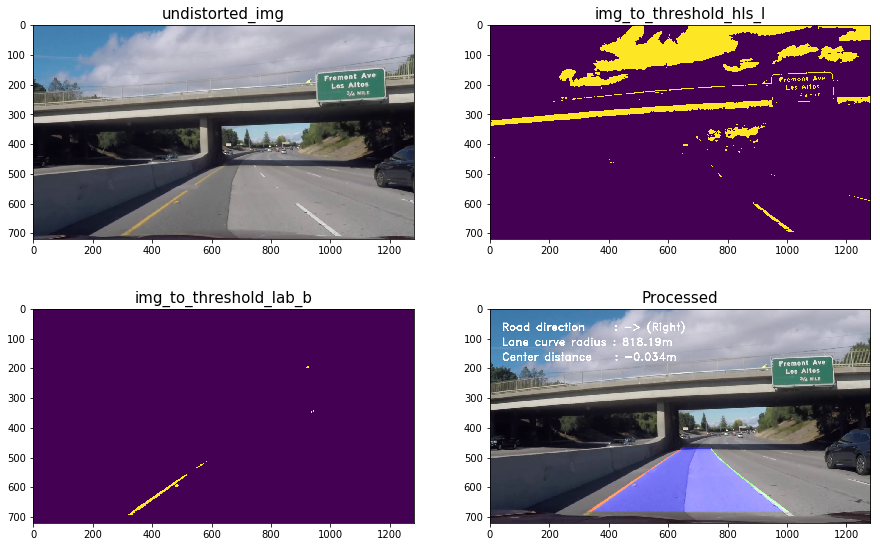

In [305]:
#load our test image

# #poor white line detection
# img1 = plt.imread("camera_input/challenge_video/frame340.jpg") 

#high curve
img1 = plt.imread("camera_input/challenge_video/frame100.jpg") 

# #dark bridge section
# img1 = plt.imread("camera_input/challenge_video/frame135.jpg") 

# #good test image
# img1 = plt.imread("test_images/test5.jpg") 

#HSV colorspace
hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).
print(hsv_v_channel.mean())


#test some pipeline parts
fig = plt.figure(figsize=(15, 20))

#undistort the image
undistorted_img = undistort(img1)

#get image augmented colorspace
aug_img = augmented_colorspace(undistorted_img)
#get bird eye view
top_aug_img = bird_eye_view(aug_img, getMinv=False)

plt.subplot(4,2,1)
plt.imshow(undistorted_img)
plt.title('undistorted_img',fontsize=15)

plt.subplot(4,2,2)
plt.imshow(img_to_threshold_hls_l(img1))
plt.title('img_to_threshold_hls_l',fontsize=15)

plt.subplot(4,2,3)
plt.imshow(img_to_threshold_lab_b(img1))
plt.title('img_to_threshold_lab_b',fontsize=15)

out_img= Process_video_frame(img1)
plt.subplot(4,2,4)
plt.imshow(out_img)
plt.title('Processed',fontsize=15)
